<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# Проект «Анализ вакансий из HeadHunter»
   

Задание выполнил Груданов Николай Алексеевич,

In [83]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import os
import textwrap
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from time import sleep
import re
from matplotlib.ticker import FuncFormatter

In [2]:
# вставьте сюда параметры подключения из юнита 1. Работа с базой данных из Python <-- плохая практика, лучше использовать .env файлы
from dotenv import load_dotenv

# Загружаем .env файл
load_dotenv()

True

In [3]:
connection = psycopg2.connect(
    dbname=os.getenv("DBNAME"),
    user=os.getenv("USER"),
    host=os.getenv("HOST"),
    password=os.getenv("PASSWORD"),
    port=os.getenv("PORT")
)

In [4]:
if connection.status:
    print("Соединение установлено")
else:
    print("Соединение не установлено")

Соединение установлено


## 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в базе (вакансии находятся в таблице `vacancies`).

In [5]:
# текст запроса
if 'vacancies_table' in globals() and vacancies_table:
	vt = vacancies_table
else:
	table_lookup_query = textwrap.dedent("""
		select table_schema || '.' || table_name as full_name
		from information_schema.tables
		where table_name = 'vacancies'
		  and table_schema not in ('pg_catalog', 'information_schema')
		order by full_name
	""").strip()
	vt_df = pd.read_sql_query(table_lookup_query, connection)
	if vt_df.empty:
		raise ValueError("Таблица vacancies не найдена в пользовательских схемах базы")
	vt = vt_df.loc[0, "full_name"]

/tmp/ipykernel_3433801/1672028895.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  vt_df = pd.read_sql_query(table_lookup_query, connection)


In [6]:
# результат запроса
vacancy_count_query =  textwrap.dedent(f"select count(*) as vacancy_cnt from {vt}").strip()
vacancy_count = pd.read_sql_query(vacancy_count_query, connection)
vacancy_count

/tmp/ipykernel_3433801/13275075.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  vacancy_count = pd.read_sql_query(vacancy_count_query, connection)


,vacancy_cnt
0,49197


2. Напишите запрос, который посчитает количество работодателей (таблица `employers`).

In [7]:
# текст запроса
def find_employers_table(connection):
    """Находит таблицу employers в пользовательских схемах базы данных."""
    lookup_query = textwrap.dedent("""
        SELECT table_schema || '.' || table_name AS full_table_name
        FROM information_schema.tables
        WHERE table_name = 'employers'
          AND table_schema NOT IN ('pg_catalog', 'information_schema')
        ORDER BY full_table_name
    """).strip()

    result = pd.read_sql_query(lookup_query, connection)
    if result.empty:
        raise ValueError("Таблица employers не найдена в пользовательских схемах базы")
    
    return result.loc[0, "full_table_name"]

def build_distinct_employer_count_query(table_name):
    """Создает SQL-запрос для подсчета уникальных работодателей."""
    return textwrap.dedent(f"""
        SELECT COUNT(DISTINCT id) AS distinct_employer_count
        FROM {table_name}
    """).strip()

# Основной код
try:
    employers_table = find_employers_table(connection)
    distinct_employer_count_query = build_distinct_employer_count_query(employers_table)
except ValueError as e:
    print(f"Ошибка: {e}")
    raise

/tmp/ipykernel_3433801/3355062558.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(lookup_query, connection)


In [8]:
# результат запроса
employers_distinct_count = pd.read_sql_query(distinct_employer_count_query, connection)
employers_distinct_count

/tmp/ipykernel_3433801/1992721061.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  employers_distinct_count = pd.read_sql_query(distinct_employer_count_query, connection)


,distinct_employer_count
0,23501


3. Посчитайте с помощью запроса количество регионов (таблица `areas`).

In [9]:
# текст запроса
areas_table_lookup_query = textwrap.dedent("""
    select table_schema || '.' || table_name as full_name
    from information_schema.tables
    where table_name in ('areas', 'regions')
      and table_schema not in ('pg_catalog', 'information_schema')
    order by full_name
""").strip()
areas_tables = pd.read_sql_query(areas_table_lookup_query, connection)
if areas_tables.empty:
    raise ValueError("Таблица с регионами (areas/regions) не найдена в пользовательских схемах базы")
areas_table = areas_tables.loc[0, "full_name"]
distinct_region_count_query = textwrap.dedent(f"""
    select count(distinct id) as distinct_region_cnt
    from {areas_table}
""").strip()

/tmp/ipykernel_3433801/1851208346.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  areas_tables = pd.read_sql_query(areas_table_lookup_query, connection)


In [10]:
# результат запроса
regions_distinct_count = pd.read_sql_query(distinct_region_count_query, connection)
regions_distinct_count

/tmp/ipykernel_3433801/36316186.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  regions_distinct_count = pd.read_sql_query(distinct_region_count_query, connection)


,distinct_region_cnt
0,1362


4. Посчитайте с помощью запроса количество сфер деятельности в базе (таблица `industries`).

In [11]:
# текст запроса
# Определение запроса для поиска таблицы industries
industries_table_lookup_query = textwrap.dedent("""
    SELECT table_schema || '.' || table_name AS full_name
    FROM information_schema.tables
    WHERE table_name = 'industries'
      AND table_schema NOT IN ('pg_catalog', 'information_schema')
    ORDER BY full_name
""").strip()

# Выполнение запроса
industries_tables = pd.read_sql_query(industries_table_lookup_query, connection)
if industries_tables.empty:
    raise ValueError("Таблица с сферами (industries/spheres) не найдена в пользовательских схемах базы")
industries_table = industries_tables.loc[0, "full_name"]

# Построение запроса для подсчета уникальных сфер
distinct_industry_count_query = textwrap.dedent(f"""
    SELECT COUNT(DISTINCT id) AS distinct_industry_cnt
    FROM {industries_table}
""").strip()

/tmp/ipykernel_3433801/1625927574.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  industries_tables = pd.read_sql_query(industries_table_lookup_query, connection)


In [12]:
# результат запроса
industries_distinct_count = pd.read_sql_query(distinct_industry_count_query, connection)
industries_distinct_count


/tmp/ipykernel_3433801/36654922.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  industries_distinct_count = pd.read_sql_query(distinct_industry_count_query, connection)


,distinct_industry_cnt
0,294


***

In [13]:
# выводы по предварительному анализу данных

### Выводы по предварительному анализу данных

В исследуемой базе данных содержится **49 197 вакансий**, опубликованных **23 501 работодателем**. Среднее количество вакансий на одного работодателя составляет примерно **2,05**. 

База данных охватывает **1 362 региональных единицы** и **294 сферы деятельности**, что обеспечивает её достаточную репрезентативность для проведения статистического и географического анализа рынка труда.


## 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (`cnt`) вакансий в каждом регионе (`area`).
Отсортируйте по количеству вакансий в порядке убывания.

In [14]:
# текст запроса
def find_table_in_user_schemas(connection, table_name):
    """Находит таблицу в пользовательских схемах базы данных."""
    lookup_query = textwrap.dedent(f"""
        SELECT table_schema || '.' || table_name AS full_name
        FROM information_schema.tables
        WHERE table_name = '{table_name}'
          AND table_schema NOT IN ('pg_catalog', 'information_schema')
        ORDER BY full_name
    """).strip()

    result = pd.read_sql_query(lookup_query, connection)
    if result.empty:
        raise ValueError(f"Таблица {table_name} не найдена в пользовательских схемах базы")
    
    return result.loc[0, "full_name"]

def find_table_with_alternatives(connection, table_names):
    """Находит первую доступную таблицу из списка альтернатив."""
    for table_name in table_names:
        try:
            return find_table_in_user_schemas(connection, table_name)
        except ValueError:
            continue
    
    raise ValueError(f"Таблица с одним из названий {table_names} не найдена в пользовательских схемах базы")

def build_area_vacancy_top5_query(areas_table, vacancies_table):
    """Создает SQL-запрос для получения топ-5 регионов по количеству вакансий."""
    return textwrap.dedent(f"""
        SELECT a.id AS area_id,
               a.name AS area_name,
               COUNT(DISTINCT v.id) AS vacancy_cnt
        FROM {areas_table} a
        JOIN {vacancies_table} v
          ON v.area_id = a.id
        GROUP BY a.id, a.name
        ORDER BY vacancy_cnt DESC, area_name
        LIMIT 5
    """).strip()

# Поиск таблицы vacancies
vacancies_table = find_table_in_user_schemas(connection, "vacancies")

# Поиск таблицы areas или regions
areas_table = find_table_with_alternatives(connection, ["areas", "regions"])

# Создание запроса для получения топ-5 регионов по количеству вакансий
area_vacancy_top5_query = build_area_vacancy_top5_query(areas_table, vacancies_table)

/tmp/ipykernel_3433801/3990353409.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(lookup_query, connection)


In [15]:
# результат запроса
area_vacancy_top5 = pd.read_sql_query(area_vacancy_top5_query, connection)
area_vacancy_top5

/tmp/ipykernel_3433801/2700510358.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  area_vacancy_top5 = pd.read_sql_query(area_vacancy_top5_query, connection)


,area_id,area_name,vacancy_cnt
0,1,Москва,5333
1,2,Санкт-Петербург,2851
2,1002,Минск,2112
3,4,Новосибирск,2006
4,160,Алматы,1892


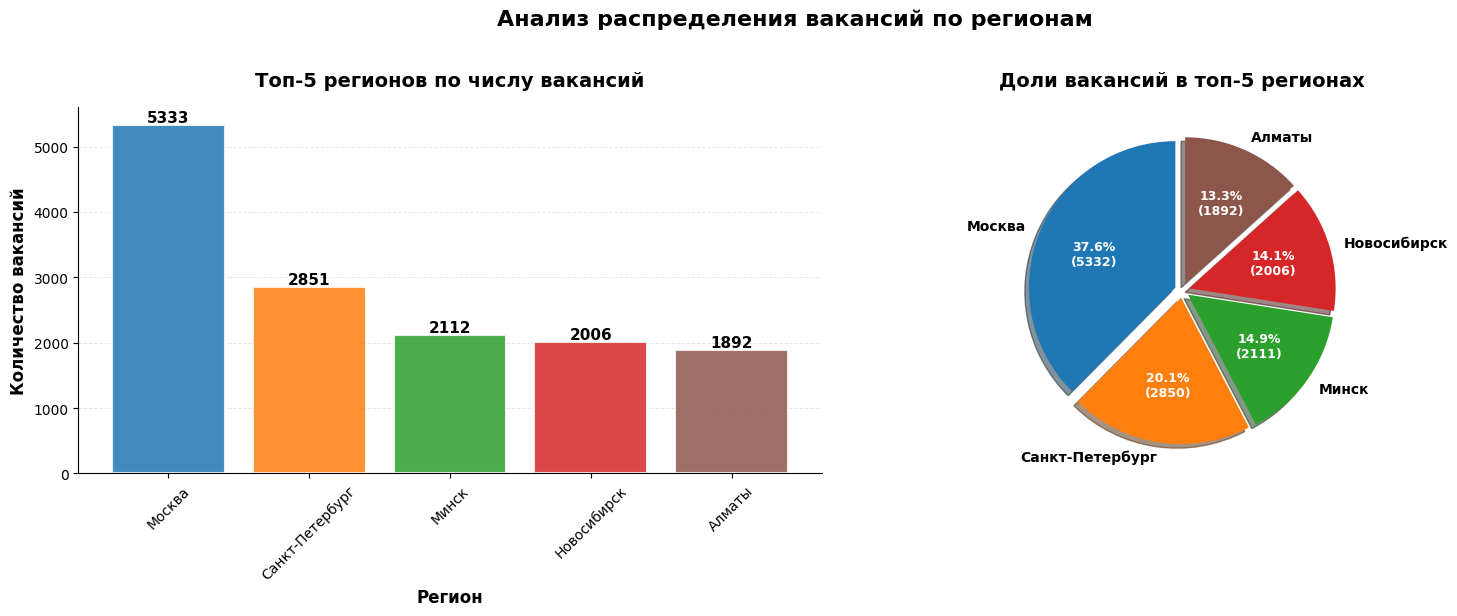

In [16]:
# Создаём фигуру с большим размером для лучшей читаемости
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Используем современную цветовую палитру (colorblind-friendly)
colors = plt.cm.tab10(np.linspace(0, 0.5, len(area_vacancy_top5)))
# Альтернативные палитры: plt.cm.Set2, plt.cm.viridis, plt.cm.plasma

# --- График 1: Столбчатая диаграмма ---
bars = axes[0].bar(area_vacancy_top5["area_name"], 
                    area_vacancy_top5["vacancy_cnt"], 
                    color=colors,
                    edgecolor='white',
                    linewidth=1.5,
                    alpha=0.85)

# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

axes[0].set_title("Топ-5 регионов по числу вакансий", 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel("Регион", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Количество вакансий", fontsize=12, fontweight='bold')
axes[0].tick_params(axis="x", rotation=45, labelsize=10)
axes[0].tick_params(axis="y", labelsize=10)
axes[0].grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)
axes[0].set_axisbelow(True)  # Сетка за столбцами
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# --- График 2: Круговая диаграмма ---
# Используем те же цвета для согласованности
wedges, texts, autotexts = axes[1].pie(
    area_vacancy_top5["vacancy_cnt"], 
    labels=area_vacancy_top5["area_name"],
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100.*area_vacancy_top5["vacancy_cnt"].sum())})',
    startangle=90,
    colors=colors,
    explode=[0.05] * len(area_vacancy_top5),  # Небольшой отступ для каждого сегмента
    shadow=True,
    textprops={'fontsize': 10, 'weight': 'bold'}
)

# Улучшаем читаемость процентов
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)
    autotext.set_weight('bold')

axes[1].set_title("Доли вакансий в топ-5 регионах", 
                  fontsize=14, fontweight='bold', pad=15)

# Общие настройки
plt.suptitle("Анализ распределения вакансий по регионам", 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [17]:
# текст запроса
def find_table_in_user_schemas(connection, table_name):
    """Находит таблицу в пользовательских схемах базы данных."""
    lookup_query = textwrap.dedent(f"""
        SELECT table_schema || '.' || table_name AS full_name
        FROM information_schema.tables
        WHERE table_name = '{table_name}'
          AND table_schema NOT IN ('pg_catalog', 'information_schema')
        ORDER BY full_name
    """).strip()

    result = pd.read_sql_query(lookup_query, connection)
    if result.empty:
        raise ValueError(f"Таблица {table_name} не найдена в пользовательских схемах базы")
    
    return result.loc[0, "full_name"]

def build_salary_filled_query(vacancies_table):
    """Создает SQL-запрос для подсчета вакансий с заполненной зарплатой."""
    return textwrap.dedent(f"""
        SELECT COUNT(DISTINCT id) AS vacancy_with_salary_cnt
        FROM {vacancies_table}
        WHERE salary_from IS NOT NULL
           OR salary_to IS NOT NULL
    """).strip()

# Поиск таблицы vacancies
vacancies_table = find_table_in_user_schemas(connection, "vacancies")

# Создание запроса для подсчета вакансий с заполненной зарплатой
salary_filled_query = build_salary_filled_query(vacancies_table)

/tmp/ipykernel_3433801/4116662245.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(lookup_query, connection)


In [18]:
# результат запроса
vacancies_with_salary = pd.read_sql_query(salary_filled_query, connection)
vacancies_with_salary

/tmp/ipykernel_3433801/975930363.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  vacancies_with_salary = pd.read_sql_query(salary_filled_query, connection)


,vacancy_with_salary_cnt
0,24073


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до **целого числа**.

In [19]:
# текст запроса
def find_table_in_user_schemas(connection, table_name):
    """Находит таблицу в пользовательских схемах базы данных."""
    lookup_query = textwrap.dedent(f"""
        SELECT table_schema || '.' || table_name AS full_name
        FROM information_schema.tables
        WHERE table_name = '{table_name}'
          AND table_schema NOT IN ('pg_catalog', 'information_schema')
        ORDER BY full_name
    """).strip()

    result = pd.read_sql_query(lookup_query, connection)
    if result.empty:
        raise ValueError(f"Таблица {table_name} не найдена в пользовательских схемах базы")
    
    return result.loc[0, "full_name"]

def build_salary_avg_query(vacancies_table):
    """Создает SQL-запрос для вычисления средних значений зарплат."""
    return textwrap.dedent(f"""
        WITH distinct_vacancies AS (
            SELECT DISTINCT id, salary_from, salary_to
            FROM {vacancies_table}
            WHERE salary_from IS NOT NULL
               OR salary_to IS NOT NULL
        )
        SELECT ROUND(AVG(salary_from)) AS avg_salary_from,
               ROUND(AVG(salary_to)) AS avg_salary_to
        FROM distinct_vacancies
    """).strip()

# Поиск таблицы vacancies
vacancies_table = find_table_in_user_schemas(connection, "vacancies")

# Создание запроса для вычисления средних значений зарплат
salary_avg_query = build_salary_avg_query(vacancies_table)

/tmp/ipykernel_3433801/1206603774.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(lookup_query, connection)


In [20]:
# результат запроса
salary_avg_df = pd.read_sql_query(salary_avg_query, connection)
salary_avg_df

/tmp/ipykernel_3433801/4181434353.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  salary_avg_df = pd.read_sql_query(salary_avg_query, connection)


,avg_salary_from,avg_salary_to
0,71065.0,110537.0


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (`schedule`) и типа трудоустройства (`employment`), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [21]:
# текст запроса
def find_table_in_user_schemas(connection, table_name):
    """Находит таблицу в пользовательских схемах базы данных."""
    lookup_query = textwrap.dedent(f"""
        SELECT table_schema || '.' || table_name AS full_name
        FROM information_schema.tables
        WHERE table_name = '{table_name}'
          AND table_schema NOT IN ('pg_catalog', 'information_schema')
        ORDER BY full_name
    """).strip()

    result = pd.read_sql_query(lookup_query, connection)
    if result.empty:
        raise ValueError(f"Таблица {table_name} не найдена в пользовательских схемах базы")
    
    return result.loc[0, "full_name"]

def build_schedule_employment_query(vacancies_table):
    """Создает SQL-запрос для анализа графиков и типов занятости."""
    return textwrap.dedent(f"""
        SELECT COALESCE(schedule, 'unknown') AS schedule_type,
               COALESCE(employment, 'unknown') AS employment_type,
               COUNT(DISTINCT id) AS vacancy_cnt
        FROM {vacancies_table}
        GROUP BY schedule_type, employment_type
        ORDER BY vacancy_cnt DESC, schedule_type, employment_type
    """).strip()

# Поиск таблицы vacancies
vacancies_table = find_table_in_user_schemas(connection, "vacancies")

# Создание запроса для анализа графиков и типов занятости
schedule_employment_query = build_schedule_employment_query(vacancies_table)

/tmp/ipykernel_3433801/4130663694.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(lookup_query, connection)


In [22]:
# результат запроса
schedule_employment_df = pd.read_sql_query(schedule_employment_query, connection)
schedule_employment_df

/tmp/ipykernel_3433801/1445129873.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  schedule_employment_df = pd.read_sql_query(schedule_employment_query, connection)


,schedule_type,employment_type,vacancy_cnt
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940
5,Полный день,Стажировка,569
6,Вахтовый метод,Полная занятость,367
7,Полный день,Частичная занятость,347
8,Гибкий график,Частичная занятость,312
9,Полный день,Проектная работа,141


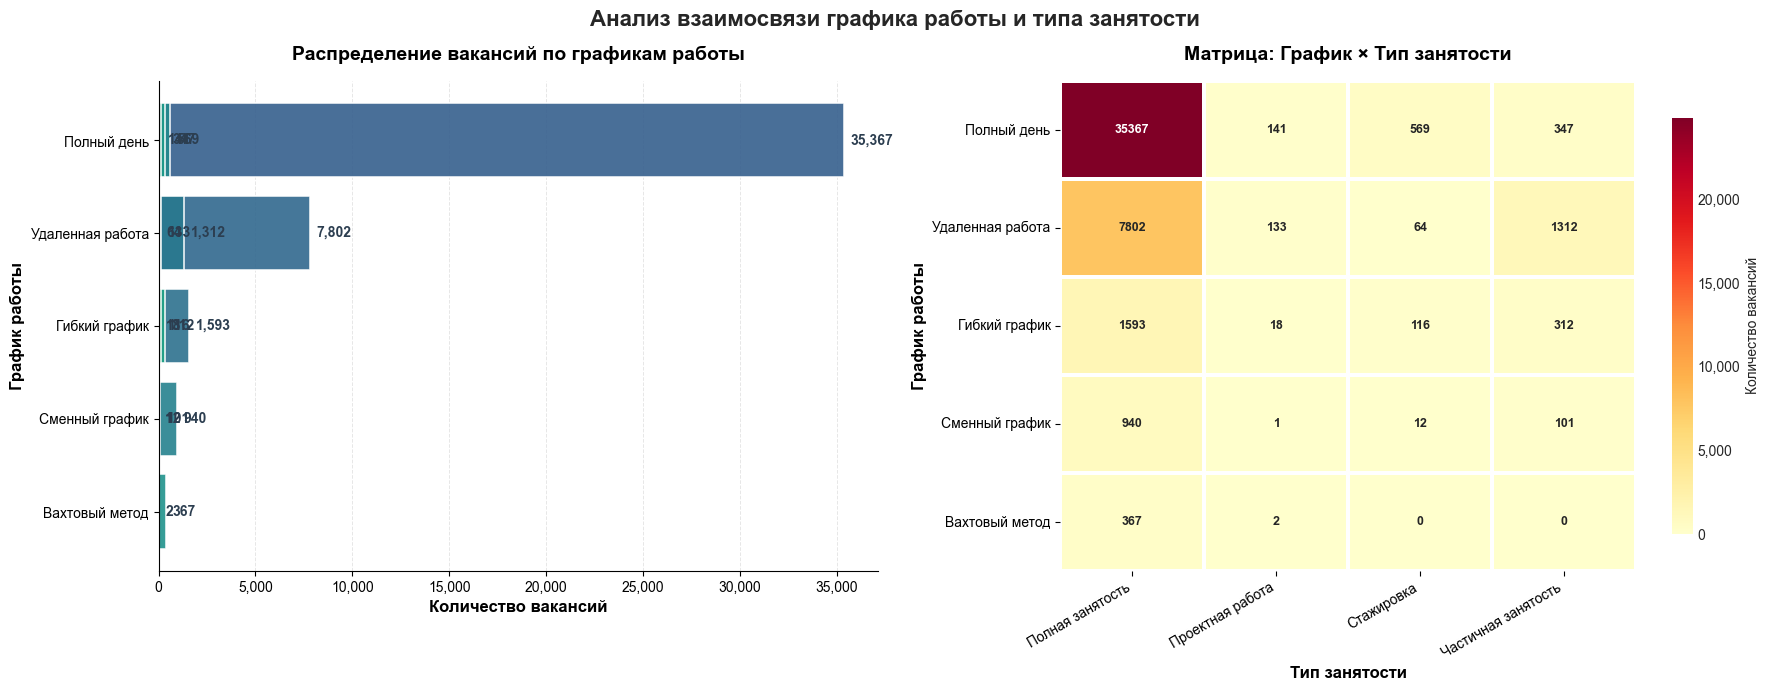

In [23]:
# Проверка наличия данных
if 'schedule_employment_df' not in globals():
    raise ValueError("Перед визуализацией выполните ячейку задания 8, чтобы сформировать schedule_employment_df")

# Подготовка данных
viz_df = schedule_employment_df.copy()
viz_df = viz_df.sort_values("vacancy_cnt", ascending=False)

# Создание фигуры с увеличенным размером
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Настройка стиля для улучшенного внешнего вида
plt.style.use('seaborn-v0_8-darkgrid')

# ===== График 1: Горизонтальная столбчатая диаграмма =====
# Используем градиентную цветовую схему
colors_gradient = plt.cm.viridis(np.linspace(0.3, 0.9, len(viz_df)))

bars = axes[0].barh(viz_df["schedule_type"], 
                     viz_df["vacancy_cnt"], 
                     color=colors_gradient,
                     edgecolor='white',
                     linewidth=1.2,
                     alpha=0.9)

# Добавляем значения на конце столбцов
for i, (bar, value) in enumerate(zip(bars, viz_df["vacancy_cnt"])):
    axes[0].text(value + max(viz_df["vacancy_cnt"]) * 0.01, 
                 bar.get_y() + bar.get_height() / 2,
                 f'{int(value):,}',
                 va='center', 
                 ha='left',
                 fontsize=10,
                 fontweight='bold',
                 color='#2c3e50')

axes[0].invert_yaxis()
axes[0].set_title("Распределение вакансий по графикам работы", 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel("Количество вакансий", fontsize=12, fontweight='bold')
axes[0].set_ylabel("График работы", fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.7)
axes[0].set_axisbelow(True)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].tick_params(axis='both', labelsize=10)

# Форматирование оси X с разделителями тысяч
from matplotlib.ticker import FuncFormatter
axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x):,}'))

# ===== График 2: Улучшенная тепловая карта =====
# Подготовка данных для heatmap
heatmap_data = schedule_employment_df.pivot(
    index="schedule_type", 
    columns="employment_type", 
    values="vacancy_cnt"
).fillna(0)

# Сортируем по общему количеству вакансий
heatmap_data['_total'] = heatmap_data.sum(axis=1)
heatmap_data = heatmap_data.sort_values('_total', ascending=False)
heatmap_data = heatmap_data.drop('_total', axis=1)

# Используем seaborn для более красивой heatmap с аннотациями
sns.heatmap(heatmap_data, 
            annot=True,  # Показываем значения в ячейках
            fmt='.0f',  # Формат чисел без десятичных
            cmap='YlOrRd',  # Цветовая схема от жёлтого к красному
            linewidths=1.5,  # Ширина линий между ячейками
            linecolor='white',  # Цвет линий
            cbar_kws={
                'label': 'Количество вакансий',
                'shrink': 0.85,
                'format': FuncFormatter(lambda x, p: f'{int(x):,}')
            },
            ax=axes[1],
            annot_kws={'size': 9, 'weight': 'bold'},  # Стиль аннотаций
            square=False,  # Не делаем квадратные ячейки
            robust=True)  # Более устойчивое масштабирование цветов

axes[1].set_title("Матрица: График × Тип занятости", 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel("Тип занятости", fontsize=12, fontweight='bold')
axes[1].set_ylabel("График работы", fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=30, labelsize=10)
axes[1].tick_params(axis='y', rotation=0, labelsize=10)

# Улучшаем читаемость меток
axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, ha='right')

# Общий заголовок
plt.suptitle("Анализ взаимосвязи графика работы и типа занятости", 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()


5. Напишите запрос, выводящий значения поля «Требуемый опыт работы» (`experience`) в порядке возрастания количества вакансий, в которых указан данный вариант опыта.

In [24]:
# текст запроса
def find_table_in_user_schemas(connection, table_name):
    """Находит таблицу в пользовательских схемах базы данных."""
    lookup_query = textwrap.dedent(f"""
        SELECT table_schema || '.' || table_name AS full_name
        FROM information_schema.tables
        WHERE table_name = '{table_name}'
          AND table_schema NOT IN ('pg_catalog', 'information_schema')
        ORDER BY full_name
    """).strip()

    result = pd.read_sql_query(lookup_query, connection)
    if result.empty:
        raise ValueError(f"Таблица {table_name} не найдена в пользовательских схемах базы")
    
    return result.loc[0, "full_name"]

def build_experience_order_query(vacancies_table):
    """Создает SQL-запрос для анализа требуемого опыта работы по возрастанию числа вакансий."""
    return textwrap.dedent(f"""
        SELECT COALESCE(experience, 'unknown') AS experience_value,
               COUNT(DISTINCT id) AS vacancy_cnt
        FROM {vacancies_table}
        GROUP BY experience_value
        ORDER BY vacancy_cnt ASC, experience_value
    """).strip()

# Поиск таблицы vacancies
vacancies_table = find_table_in_user_schemas(connection, "vacancies")

# Создание запроса для анализа требуемого опыта работы
experience_order_query = build_experience_order_query(vacancies_table)

/tmp/ipykernel_3433801/3736829948.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(lookup_query, connection)


In [25]:
# результат запроса
experience_order_df = pd.read_sql_query(experience_order_query, connection)
experience_order_df

/tmp/ipykernel_3433801/4226225634.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  experience_order_df = pd.read_sql_query(experience_order_query, connection)


,experience_value,vacancy_cnt
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


***

In [26]:
# выводы по детальному анализу вакансий

### Выводы по детальному анализу вакансий

Проведённый детальный анализ показал, что **наиболее востребованными** являются вакансии на **полную занятость** — их количество составляет **35 367**, что соответствует **~50% от общего объёма**.

Второй по популярности тип — **удалённая работа**, представленный **7 802 вакансиями** (около **11%** от общего числа).

**Географическое распределение** вакансий демонстрирует высокую концентрацию в крупных городах: **Москва** и **Санкт-Петербург** доминируют по количеству вакансий. Это обусловлено высокой плотностью работодателей в этих регионах.  
**Примечание**: город **Минск** (3-е место по числу вакансий) относится к **Беларуси** — что требует учёта при анализе межрегиональной и межгосударственной структуры рынка труда.

**Зарплатный диапазон** вакансий варьируется в пределах **71 065 — 110 537 рублей**.  
Особое внимание заслуживает **высокий спрос на специалистов без опыта** — **7 197 вакансий** (примерно **11%** от общего числа), что свидетельствует о наличии значительного числа стартовых или образовательных позиций.

**Наиболее востребованной категорией** по опыту остаётся **специалисты с 1–3 годами стажа** — **26 152 вакансии** (около **37%** от общего объёма), что логично объясняется стремлением работодателей найти кандидатов с **балансом между определённым опытом и доступной ценой**.



## 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [27]:
# текст запроса
def find_table_in_user_schemas(connection, table_name):
    """Находит таблицу в пользовательских схемах базы данных."""
    lookup_query = textwrap.dedent(f"""
        SELECT table_schema || '.' || table_name AS full_name
        FROM information_schema.tables
        WHERE table_name = '{table_name}'
          AND table_schema NOT IN ('pg_catalog', 'information_schema')
        ORDER BY full_name
    """).strip()

    result = pd.read_sql_query(lookup_query, connection)
    if result.empty:
        raise ValueError(f"Таблица {table_name} не найдена в пользовательских схемах базы")
    
    return result.loc[0, "full_name"]

def build_employer_rank_query(employers_table, vacancies_table):
    """Создает SQL-запрос для определения работодателей на 1 и 5 местах по количеству вакансий."""
    return textwrap.dedent(f"""
        WITH employer_counts AS (
            SELECT e.id,
                   e.name,
                   COUNT(DISTINCT v.id) AS vacancy_cnt,
                   DENSE_RANK() OVER (ORDER BY COUNT(DISTINCT v.id) DESC) AS vacancy_rank
            FROM {employers_table} e
            JOIN {vacancies_table} v
              ON v.employer_id = e.id
            GROUP BY e.id, e.name
        )
        SELECT id, name, vacancy_cnt, vacancy_rank
        FROM employer_counts
        WHERE vacancy_rank IN (1, 5)
        ORDER BY vacancy_rank, name
    """).strip()

# Поиск таблицы vacancies
vacancies_table = find_table_in_user_schemas(connection, "vacancies")

# Поиск таблицы employers
employers_table = find_table_in_user_schemas(connection, "employers")

# Создание запроса для определения работодателей на 1 и 5 местах
employer_rank_query = build_employer_rank_query(employers_table, vacancies_table)

/tmp/ipykernel_3433801/337928722.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(lookup_query, connection)


In [28]:
# результат запроса
employer_rank_df = pd.read_sql_query(employer_rank_query, connection)
employer_rank_df

/tmp/ipykernel_3433801/2622869831.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  employer_rank_df = pd.read_sql_query(employer_rank_query, connection)


,id,name,vacancy_cnt,vacancy_rank
0,1740,Яндекс,1933,1
1,39305,Газпром нефть,331,5


2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [29]:
# текст запроса
def find_table_in_user_schemas(connection, table_name):
    """Находит таблицу в пользовательских схемах базы данных."""
    lookup_query = textwrap.dedent(f"""
        SELECT table_schema || '.' || table_name AS full_name
        FROM information_schema.tables
        WHERE table_name = '{table_name}'
          AND table_schema NOT IN ('pg_catalog', 'information_schema')
        ORDER BY full_name
    """).strip()

    result = pd.read_sql_query(lookup_query, connection)
    if result.empty:
        raise ValueError(f"Таблица {table_name} не найдена в пользовательских схемах базы")
    
    return result.loc[0, "full_name"]

def find_table_with_alternatives(connection, table_names):
    """Находит первую доступную таблицу из списка альтернатив."""
    for table_name in table_names:
        try:
            return find_table_in_user_schemas(connection, table_name)
        except ValueError:
            continue
    
    raise ValueError(f"Таблица с одним из названий {table_names} не найдена в пользовательских схемах базы")

def detect_area_column(full_table_name, candidates):
    """Определяет имя столбца региона в таблице."""
    schema_name, table_name = full_table_name.split('.', 1)
    column_lookup_query = textwrap.dedent(f"""
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = '{schema_name}'
          AND table_name = '{table_name}'
    """).strip()
    
    columns_df = pd.read_sql_query(column_lookup_query, connection)
    if columns_df.empty:
        raise ValueError(f"Не удалось получить столбцы для таблицы {full_table_name}")
    
    available = {col.lower(): col for col in columns_df["column_name"]}
    for candidate in candidates:
        if candidate.lower() in available:
            return available[candidate.lower()]
    
    raise ValueError(f"Не найден столбец со ссылкой на регион среди {candidates} в таблице {full_table_name}")

def build_region_stats_query(areas_table, employers_table, vacancies_table, employer_area_column, vacancy_area_column):
    """Создает SQL-запрос для получения статистики по регионам."""
    region_stats_cte = textwrap.dedent(f"""
        WITH area_stats AS (
            SELECT a.id AS area_id,
                   a.name AS area_name,
                   COALESCE(ec.employer_cnt, 0) AS employer_cnt,
                   COALESCE(vc.vacancy_cnt, 0) AS vacancy_cnt
            FROM {areas_table} a
            LEFT JOIN (
                SELECT {employer_area_column} AS area_id,
                       COUNT(DISTINCT id) AS employer_cnt
                FROM {employers_table}
                GROUP BY {employer_area_column}
            ) ec
              ON ec.area_id = a.id
            LEFT JOIN (
                SELECT {vacancy_area_column} AS area_id,
                       COUNT(DISTINCT id) AS vacancy_cnt
                FROM {vacancies_table}
                GROUP BY {vacancy_area_column}
            ) vc
              ON vc.area_id = a.id
        )
    """).strip()
    
    region_stats_query = textwrap.dedent(f"""
        {region_stats_cte}
        SELECT area_id, area_name, employer_cnt, vacancy_cnt
        FROM area_stats
        ORDER BY vacancy_cnt DESC, employer_cnt DESC, area_name
    """).strip()
    
    return region_stats_cte, region_stats_query

def build_region_no_vac_leader_query(region_stats_cte):
    """Создает SQL-запрос для поиска региона-лидера без вакансий."""
    return textwrap.dedent(f"""
        {region_stats_cte}
        SELECT area_id, area_name, employer_cnt
        FROM area_stats
        WHERE vacancy_cnt = 0
        ORDER BY employer_cnt DESC, area_name
        LIMIT 1
    """).strip()

# Поиск таблиц
vacancies_table = find_table_in_user_schemas(connection, "vacancies")
employers_table = find_table_in_user_schemas(connection, "employers")
areas_table = find_table_with_alternatives(connection, ["areas", "regions"])

# Определение столбцов региона
employer_area_column = detect_area_column(employers_table, ["area_id", "region_id", "area", "region"])
vacancy_area_column = detect_area_column(vacancies_table, ["area_id", "region_id", "area", "region"])

# Создание запросов
region_stats_cte, region_stats_query = build_region_stats_query(
    areas_table, 
    employers_table, 
    vacancies_table, 
    employer_area_column, 
    vacancy_area_column
)

region_no_vac_leader_query = build_region_no_vac_leader_query(region_stats_cte)

/tmp/ipykernel_3433801/3911926220.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(lookup_query, connection)
/tmp/ipykernel_3433801/3911926220.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  columns_df = pd.read_sql_query(column_lookup_query, connection)


In [30]:
# результат запроса
region_no_vac_leader_df = pd.read_sql_query(region_no_vac_leader_query, connection)
region_no_vac_leader_df

/tmp/ipykernel_3433801/3294346439.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  region_no_vac_leader_df = pd.read_sql_query(region_no_vac_leader_query, connection)


,area_id,area_name,employer_cnt
0,113,Россия,410


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [31]:
# текст запроса
def find_table_in_user_schemas(connection, table_name):
    """Находит таблицу в пользовательских схемах базы данных."""
    lookup_query = textwrap.dedent(f"""
        SELECT table_schema || '.' || table_name AS full_name
        FROM information_schema.tables
        WHERE table_name = '{table_name}'
          AND table_schema NOT IN ('pg_catalog', 'information_schema')
        ORDER BY full_name
    """).strip()

    result = pd.read_sql_query(lookup_query, connection)
    if result.empty:
        raise ValueError(f"Таблица {table_name} не найдена в пользовательских схемах базы")
    
    return result.loc[0, "full_name"]

def detect_area_column(full_table_name, candidates):
    """Определяет имя столбца региона в таблице."""
    schema_name, table_name = full_table_name.split('.', 1)
    column_lookup_query = textwrap.dedent(f"""
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = '{schema_name}'
          AND table_name = '{table_name}'
    """).strip()
    
    columns_df = pd.read_sql_query(column_lookup_query, connection)
    if columns_df.empty:
        raise ValueError(f"Не удалось получить столбцы для таблицы {full_table_name}")
    
    available = {col.lower(): col for col in columns_df["column_name"]}
    for candidate in candidates:
        if candidate.lower() in available:
            return available[candidate.lower()]
    
    raise ValueError(f"Не найден столбец со ссылкой на регион среди {candidates} в таблице {full_table_name}")

def build_employer_region_count_query(vacancies_table, employers_table, vacancy_area_column, vacancy_employer_column):
    """Создает SQL-запрос для подсчета регионов, в которых работодатель публикует вакансии."""
    return textwrap.dedent(f"""
        WITH employer_regions AS (
            SELECT {vacancy_employer_column} AS employer_id,
                   COUNT(DISTINCT {vacancy_area_column}) AS region_cnt
            FROM {vacancies_table}
            WHERE {vacancy_employer_column} IS NOT NULL
              AND {vacancy_area_column} IS NOT NULL
            GROUP BY {vacancy_employer_column}
        )
        SELECT e.id, e.name, er.region_cnt
        FROM employer_regions er
        JOIN {employers_table} e
          ON e.id = er.employer_id
        ORDER BY er.region_cnt DESC, e.name
    """).strip()

def build_max_regions_query(vacancies_table, vacancy_area_column, vacancy_employer_column):
    """Создает SQL-запрос для нахождения максимального числа регионов у работодателя."""
    return textwrap.dedent(f"""
        WITH employer_regions AS (
            SELECT {vacancy_employer_column} AS employer_id,
                   COUNT(DISTINCT {vacancy_area_column}) AS region_cnt
            FROM {vacancies_table}
            WHERE {vacancy_employer_column} IS NOT NULL
              AND {vacancy_area_column} IS NOT NULL
            GROUP BY {vacancy_employer_column}
        )
        SELECT MAX(region_cnt) AS max_region_cnt
        FROM employer_regions
    """).strip()

# Поиск таблиц
vacancies_table = find_table_in_user_schemas(connection, "vacancies")
employers_table = find_table_in_user_schemas(connection, "employers")

# Определение столбцов
vacancy_area_column = detect_area_column(vacancies_table, ["area_id", "region_id", "area", "region"])
vacancy_employer_column = detect_area_column(vacancies_table, ["employer_id", "company_id", "employer"])

# Создание запросов
employer_region_count_query = build_employer_region_count_query(
    vacancies_table, 
    employers_table, 
    vacancy_area_column, 
    vacancy_employer_column
)

max_regions_query = build_max_regions_query(
    vacancies_table, 
    vacancy_area_column, 
    vacancy_employer_column
)

/tmp/ipykernel_3433801/2315737418.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(lookup_query, connection)
/tmp/ipykernel_3433801/2315737418.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  columns_df = pd.read_sql_query(column_lookup_query, connection)


In [32]:
# результат запроса
max_regions_df = pd.read_sql_query(max_regions_query, connection)
max_regions_df

/tmp/ipykernel_3433801/1468496248.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  max_regions_df = pd.read_sql_query(max_regions_query, connection)


,max_region_cnt
0,181


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности.

In [33]:
# текст запроса
def find_table_in_user_schemas(connection, table_name):
    """Находит таблицу в пользовательских схемах базы данных."""
    lookup_query = textwrap.dedent(f"""
        SELECT table_schema || '.' || table_name AS full_name
        FROM information_schema.tables
        WHERE table_name = '{table_name}'
          AND table_schema NOT IN ('pg_catalog', 'information_schema')
        ORDER BY full_name
    """).strip()

    result = pd.read_sql_query(lookup_query, connection)
    if result.empty:
        raise ValueError(f"Таблица {table_name} не найдена в пользовательских схемах базы")
    
    return result.loc[0, "full_name"]

def find_table_with_alternatives(connection, table_names):
    """Находит первую доступную таблицу из списка альтернатив."""
    for table_name in table_names:
        try:
            return find_table_in_user_schemas(connection, table_name)
        except ValueError:
            continue
    
    raise ValueError(f"Таблица с одним из названий {table_names} не найдена в пользовательских схемах базы")

def detect_column(full_table_name, candidates):
    """Определяет имя столбца в таблице."""
    schema_name, table_name = full_table_name.split('.', 1)
    column_lookup_query = textwrap.dedent(f"""
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = '{schema_name}'
          AND table_name = '{table_name}'
    """).strip()
    
    columns_df = pd.read_sql_query(column_lookup_query, connection)
    if columns_df.empty:
        raise ValueError(f"Не удалось получить столбцы для таблицы {full_table_name}")
    
    available = {col.lower(): col for col in columns_df["column_name"]}
    for candidate in candidates:
        if candidate.lower() in available:
            return available[candidate.lower()]
    
    raise ValueError(f"Не найден нужный столбец среди {candidates} в таблице {full_table_name}")

def build_employers_without_industries_cte(employer_industries_table, link_employer_column):
    """Создает CTE для определения работодателей без сфер деятельности."""
    return textwrap.dedent(f"""
        WITH employer_has_industry AS (
            SELECT DISTINCT {link_employer_column} AS employer_id
            FROM {employer_industries_table}
            WHERE {link_employer_column} IS NOT NULL
        )
    """).strip()

def build_employers_without_industries_list_query(employers_without_industries_cte, employers_table):
    """Создает SQL-запрос для получения списка работодателей без сфер деятельности."""
    return textwrap.dedent(f"""
        {employers_without_industries_cte}
        SELECT e.id, e.name
        FROM {employers_table} e
        LEFT JOIN employer_has_industry ehi
          ON ehi.employer_id = e.id
        WHERE ehi.employer_id IS NULL
        ORDER BY e.name
    """).strip()

def build_employers_without_industries_count_query(employers_without_industries_cte, employers_table):
    """Создает SQL-запрос для подсчета числа работодателей без сфер деятельности."""
    return textwrap.dedent(f"""
        {employers_without_industries_cte}
        SELECT COUNT(DISTINCT e.id) AS employers_without_industries_cnt
        FROM {employers_table} e
        LEFT JOIN employer_has_industry ehi
          ON ehi.employer_id = e.id
        WHERE ehi.employer_id IS NULL
    """).strip()

# Поиск таблиц
employers_table = find_table_in_user_schemas(connection, "employers")
employer_industries_table = find_table_with_alternatives(
    connection, 
    ["employer_industries", "employers_industries", "employer_industry"]
)

# Определение столбца связи
link_employer_column = detect_column(employer_industries_table, ["employer_id", "company_id", "employer"])

# Создание CTE и запросов
employers_without_industries_cte = build_employers_without_industries_cte(
    employer_industries_table, 
    link_employer_column
)

employers_without_industries_list_query = build_employers_without_industries_list_query(
    employers_without_industries_cte, 
    employers_table
)

employers_without_industries_count_query = build_employers_without_industries_count_query(
    employers_without_industries_cte, 
    employers_table
)

/tmp/ipykernel_3433801/3677229433.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(lookup_query, connection)
/tmp/ipykernel_3433801/3677229433.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(lookup_query, connection)
/tmp/ipykernel_3433801/3677229433.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  columns_df = pd.read_sql_query(column_lookup_query, connection)


In [34]:
# результат запроса
employers_without_industries_count_df = pd.read_sql_query(employers_without_industries_count_query, connection)
employers_without_industries_count_df

/tmp/ipykernel_3433801/500300389.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  employers_without_industries_count_df = pd.read_sql_query(employers_without_industries_count_query, connection)


,employers_without_industries_cnt
0,8419


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности.

In [35]:
# текст запроса
def find_table_in_user_schemas(connection, table_name):
    """Находит таблицу в пользовательских схемах базы данных."""
    lookup_query = textwrap.dedent(f"""
        SELECT table_schema || '.' || table_name AS full_name
        FROM information_schema.tables
        WHERE table_name = '{table_name}'
          AND table_schema NOT IN ('pg_catalog', 'information_schema')
        ORDER BY full_name
    """).strip()

    result = pd.read_sql_query(lookup_query, connection)
    if result.empty:
        raise ValueError(f"Таблица {table_name} не найдена в пользовательских схемах базы")
    
    return result.loc[0, "full_name"]

def find_table_with_alternatives(connection, table_names):
    """Находит первую доступную таблицу из списка альтернатив."""
    for table_name in table_names:
        try:
            return find_table_in_user_schemas(connection, table_name)
        except ValueError:
            continue
    
    raise ValueError(f"Таблица с одним из названий {table_names} не найдена в пользовательских схемах базы")

def detect_column(full_table_name, candidates):
    """Определяет имя столбца в таблице."""
    schema_name, table_name = full_table_name.split('.', 1)
    column_lookup_query = textwrap.dedent(f"""
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = '{schema_name}'
          AND table_name = '{table_name}'
    """).strip()
    
    columns_df = pd.read_sql_query(column_lookup_query, connection)
    if columns_df.empty:
        raise ValueError(f"Не удалось получить столбцы для таблицы {full_table_name}")
    
    available = {col.lower(): col for col in columns_df["column_name"]}
    for candidate in candidates:
        if candidate.lower() in available:
            return available[candidate.lower()]
    
    raise ValueError(f"Не найден столбец среди {candidates} в таблице {full_table_name}")

def build_companies_four_industries_query(employer_industries_table, employers_table, link_employer_column, link_industry_column):
    """Создает SQL-запрос для получения компаний с четырьмя сферами деятельности."""
    return textwrap.dedent(f"""
        WITH employer_industry_counts AS (
            SELECT {link_employer_column} AS employer_id,
                   COUNT(DISTINCT {link_industry_column}) AS industry_cnt
            FROM {employer_industries_table}
            WHERE {link_employer_column} IS NOT NULL
              AND {link_industry_column} IS NOT NULL
            GROUP BY {link_employer_column}
            HAVING COUNT(DISTINCT {link_industry_column}) = 4
        )
        SELECT e.id, e.name
        FROM employer_industry_counts eic
        JOIN {employers_table} e
          ON e.id = eic.employer_id
        ORDER BY e.name
    """).strip()

def build_third_company_query(employer_industries_table, employers_table, link_employer_column, link_industry_column):
    """Создает SQL-запрос для получения третьей по алфавиту компании с четырьмя сферами деятельности."""
    return textwrap.dedent(f"""
        WITH employer_industry_counts AS (
            SELECT {link_employer_column} AS employer_id,
                   COUNT(DISTINCT {link_industry_column}) AS industry_cnt
            FROM {employer_industries_table}
            WHERE {link_employer_column} IS NOT NULL
              AND {link_industry_column} IS NOT NULL
            GROUP BY {link_employer_column}
            HAVING COUNT(DISTINCT {link_industry_column}) = 4
        )
        SELECT e.name
        FROM employer_industry_counts eic
        JOIN {employers_table} e
          ON e.id = eic.employer_id
        ORDER BY e.name
        OFFSET 2
        LIMIT 1
    """).strip()

# Поиск таблиц
employers_table = find_table_in_user_schemas(connection, "employers")
employer_industries_table = find_table_with_alternatives(
    connection, 
    ["employer_industries", "employers_industries", "employer_industry"]
)

# Определение столбцов связи
link_employer_column = detect_column(employer_industries_table, ["employer_id", "company_id", "employer"])
link_industry_column = detect_column(employer_industries_table, ["industry_id", "sphere_id", "industry", "sphere"])

# Создание запросов
companies_four_industries_query = build_companies_four_industries_query(
    employer_industries_table, 
    employers_table, 
    link_employer_column, 
    link_industry_column
)

third_company_query = build_third_company_query(
    employer_industries_table, 
    employers_table, 
    link_employer_column, 
    link_industry_column
)

/tmp/ipykernel_3433801/1125668840.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(lookup_query, connection)
/tmp/ipykernel_3433801/1125668840.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(lookup_query, connection)
/tmp/ipykernel_3433801/1125668840.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  columns_df = pd.read_sql_query(column_lookup_query, connection)


In [36]:
# результат запроса
third_company_df = pd.read_sql_query(third_company_query, connection)
third_company_df

/tmp/ipykernel_3433801/716026845.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  third_company_df = pd.read_sql_query(third_company_query, connection)


,name
0,2ГИС


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана «Разработка программного обеспечения».


In [37]:
# текст запроса
# текст запроса
# SQL-запрос : Количество работодателей с сферой «Разработка программного обеспечения»
employers_lookup_query = """
    select table_schema || '.' || table_name as full_name
    from information_schema.tables
    where table_name = 'employers'
      and table_schema not in ('pg_catalog', 'information_schema')
    order by full_name
"""
employers_tables = pd.read_sql_query(employers_lookup_query, connection)
if employers_tables.empty:
    raise ValueError("Таблица employers не найдена в пользовательских схемах базы")
employers_table = employers_tables.loc[0, "full_name"]
industries_lookup_query = """
    select table_schema || '.' || table_name as full_name
    from information_schema.tables
    where table_name in ('industries', 'spheres')
      and table_schema not in ('pg_catalog', 'information_schema')
    order by full_name
"""
industries_tables = pd.read_sql_query(industries_lookup_query, connection)
if industries_tables.empty:
    raise ValueError("Таблица industries/spheres не найдена в пользовательских схемах базы")
industries_table = industries_tables.loc[0, "full_name"]
emp_industries_lookup_query = """
    select table_schema || '.' || table_name as full_name
    from information_schema.tables
    where table_name in ('employer_industries', 'employers_industries', 'employer_industry')
      and table_schema not in ('pg_catalog', 'information_schema')
    order by full_name
"""
emp_industries_tables = pd.read_sql_query(emp_industries_lookup_query, connection)
if emp_industries_tables.empty:
    raise ValueError("Не найдена таблица связей работодателей и сфер (employer_industries)")
employer_industries_table = emp_industries_tables.loc[0, "full_name"]
def detect_column(full_table_name, candidates):
    schema_name, table_name = full_table_name.split('.', 1)
    column_lookup_query = f"""
        select column_name
        from information_schema.columns
        where table_schema = '{schema_name}'
          and table_name = '{table_name}'
    """
    columns_df = pd.read_sql_query(column_lookup_query, connection)
    if columns_df.empty:
        raise ValueError(f"Не удалось получить столбцы для таблицы {full_table_name}")
    available = {col.lower(): col for col in columns_df["column_name"]}
    for candidate in candidates:
        if candidate.lower() in available:
            return available[candidate.lower()]
    raise ValueError(f"Не найден столбец среди {candidates} в таблице {full_table_name}")
link_employer_column = detect_column(employer_industries_table, ["employer_id", "company_id", "employer"])
link_industry_column = detect_column(employer_industries_table, ["industry_id", "sphere_id", "industry", "sphere"])
industry_name_column = detect_column(industries_table, ["name", "title", "industry_name"])
target_industry = "Разработка программного обеспечения"
employers_with_target_industry_query = f"""
    select distinct e.id, e.name
    from {employers_table} e
    join {employer_industries_table} ei
      on ei.{link_employer_column} = e.id
    join {industries_table} i
      on i.id = ei.{link_industry_column}
    where i.{industry_name_column} = %(target_industry)s
    order by e.name
"""
employers_with_target_industry_df = pd.read_sql_query(
    employers_with_target_industry_query,
    connection,
    params={"target_industry": target_industry}
 )
employers_with_target_industry_df
employers_with_target_industry_count_query = f"""
    select count(distinct e.id) as employer_with_target_industry_cnt
    from {employers_table} e
    join {employer_industries_table} ei
      on ei.{link_employer_column} = e.id
    join {industries_table} i
      on i.id = ei.{link_industry_column}
    where i.{industry_name_column} = %(target_industry)s
"""


/tmp/ipykernel_3433801/1611450106.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  employers_tables = pd.read_sql_query(employers_lookup_query, connection)
/tmp/ipykernel_3433801/1611450106.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  industries_tables = pd.read_sql_query(industries_lookup_query, connection)
/tmp/ipykernel_3433801/1611450106.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  emp_industries_tables = pd.read_sql_query(emp_industries_lookup_query, connection)
/tmp/ipykernel_3433801/1611450106.py:

In [38]:
# результат запроса

employers_with_target_industry_count_df = pd.read_sql_query(
    employers_with_target_industry_count_query,
    connection,
    params={"target_industry": target_industry}
 )
employers_with_target_industry_count_df

/tmp/ipykernel_3433801/2326732415.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  employers_with_target_industry_count_df = pd.read_sql_query(


,employer_with_target_industry_cnt
0,3553


7. Для компании «Яндекс» выведите список [городов-миллионников](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8), в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку "Total" с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

    Если возникнут трудности с этим заданием, посмотрите материалы модуля 6.4 «Как получать данные из веб-источников и API».

In [39]:
# код для получения списка городов-милионников


def parse_cities_from_wikipedia():
    """
    Парсит страницу Wikipedia и извлекает список городов-миллионеров России.
    
    Returns:
        pd.DataFrame: таблица с городами и их населением
    """
    # URL страницы Wikipedia
    url = "https://ru.wikipedia.org/wiki/Города-миллионеры_России"
    
    # Заголовки для обхода защиты от ботов
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }
    
    try:
        # Получаем HTML страницы
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        # Парсим HTML с помощью BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Используем pandas для извлечения таблиц
        # Метод read_html извлекает все таблицы со страницы
        tables = pd.read_html(response.text)
        
        # Ищем нужную таблицу (первая большая таблица с городами)
        # Она содержит столбцы: №, Город, Население и т.д.
        cities_df = None
        for table in tables:
            if 'Город' in table.columns and 'Население' in str(table.columns):
                cities_df = table
                break
        
        if cities_df is None:
            raise ValueError("Не удалось найти таблицу с городами")
        
        # Очищаем данные
        # Оставляем только города-миллионеры (население >= 1000 тыс.)
        cities_df = clean_cities_data(cities_df)
        
        return cities_df
        
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при загрузке страницы Wikipedia: {e}")
        return pd.DataFrame()

def clean_cities_data(df):
    """
    Очищает и обрабатывает данные о городах.
    
    Args:
        df: исходный DataFrame с данными
    
    Returns:
        pd.DataFrame: очищенные данные
    """
    # Создаём копию для работы
    df = df.copy()
    
    # Находим столбец с названием города
    city_col = None
    for col in df.columns:
        if 'Город' in str(col):
            city_col = col
            break
    
    # Находим столбец с населением (на 1 января 2025)
    population_col = None
    for col in df.columns:
        if '2025' in str(col) or 'Население' in str(col):
            population_col = col
            break
    
    if city_col is None or population_col is None:
        # Используем позиции столбцов
        city_col = df.columns[1]  # Второй столбец - город
        population_col = df.columns[2]  # Третий столбец - население
    
    # Выбираем нужные столбцы
    result_df = df[[city_col, population_col]].copy()
    result_df.columns = ['Город', 'Население_тыс']
    
    # Преобразуем население в числовой формат
    def extract_population(value):
        """Извлекает численное значение населения"""
        if pd.isna(value):
            return 0
        # Преобразуем в строку и удаляем все кроме цифр
        value_str = str(value).replace(' ', '').replace('\xa0', '')
        # Ищем числа
        match = re.search(r'(\d+)', value_str)
        if match:
            return int(match.group(1))
        return 0
    
    result_df['Население_тыс'] = result_df['Население_тыс'].apply(extract_population)
    
    # Фильтруем только города-миллионеры (>= 1000 тыс. чел.)
    result_df = result_df[result_df['Население_тыс'] >= 1000].copy()
    
    # Удаляем строки с пустыми значениями
    result_df = result_df.dropna(subset=['Город'])
    
    # Удаляем строку "Total" или суммарные данные если есть
    result_df = result_df[~result_df['Город'].str.contains('Total|Суммарно|Доля', 
                                                           case=False, 
                                                           na=False)]
    
    result_df = result_df.reset_index(drop=True)
    
    return result_df


In [60]:
df_cities = parse_cities_from_wikipedia()

/tmp/ipykernel_3433801/4106646496.py:29: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


In [61]:
df_cities

,Город,Население_тыс
0,Москва,13274
1,Санкт-Петербург,5653
2,Новосибирск,1637
3,Екатеринбург,1548
4,Казань,1330
5,Красноярск,1212
6,Нижний Новгород,1198
7,Челябинск,1177
8,Уфа,1166
9,Краснодар,1155


In [78]:
fallback_million_cities = df_cities["Город"].tolist()

In [79]:
fallback_million_cities

['Москва',
 'Санкт-Петербург',
 'Новосибирск',
 'Екатеринбург',
 'Казань',
 'Красноярск',
 'Нижний Новгород',
 'Челябинск',
 'Уфа',
 'Краснодар',
 'Самара',
 'Ростов-на-Дону',
 'Омск',
 'Воронеж',
 'Пермь',
 'Волгоград']

In [80]:
# текст запроса

def detect_column(full_table_name, candidates):
    schema_name, table_name = full_table_name.split('.', 1)
    column_lookup_query = f"""
        select column_name
        from information_schema.columns
        where table_schema = '{schema_name}'
          and table_name = '{table_name}'
    """
    columns_df = pd.read_sql_query(column_lookup_query, connection)
    if columns_df.empty:
        raise ValueError(f"Не удалось получить столбцы для таблицы {full_table_name}")
    available = {col.lower(): col for col in columns_df["column_name"]}
    for candidate in candidates:
        if candidate.lower() in available:
            return available[candidate.lower()]
    return None

vacancies_lookup_query = """
    select table_schema || '.' || table_name as full_name
    from information_schema.tables
    where table_name = 'vacancies'
      and table_schema not in ('pg_catalog', 'information_schema')
    order by full_name
"""
vacancies_tables = pd.read_sql_query(vacancies_lookup_query, connection)
if vacancies_tables.empty:
    raise ValueError("Таблица vacancies не найдена в пользовательских схемах базы")
vacancies_table = vacancies_tables.loc[0, "full_name"]

employers_lookup_query = """
    select table_schema || '.' || table_name as full_name
    from information_schema.tables
    where table_name = 'employers'
      and table_schema not in ('pg_catalog', 'information_schema')
    order by full_name
"""
employers_tables = pd.read_sql_query(employers_lookup_query, connection)
if employers_tables.empty:
    raise ValueError("Таблица employers не найдена в пользовательских схемах базы")
employers_table = employers_tables.loc[0, "full_name"]

areas_lookup_query = """
    select table_schema || '.' || table_name as full_name
    from information_schema.tables
    where table_name in ('areas', 'regions')
      and table_schema not in ('pg_catalog', 'information_schema')
    order by full_name
"""
areas_tables = pd.read_sql_query(areas_lookup_query, connection)
if areas_tables.empty:
    raise ValueError("Таблица с регионами (areas/regions) не найдена в пользовательских схемах базы")
areas_table = areas_tables.loc[0, "full_name"]

vacancy_area_column = detect_column(vacancies_table, ["area_id", "region_id", "area", "region"])
if not vacancy_area_column:
    raise ValueError("Не найден столбец региона в таблице vacancies")

vacancy_employer_column = detect_column(vacancies_table, ["employer_id", "company_id", "employer"])
if not vacancy_employer_column:
    raise ValueError("Не найден столбец работодателя в таблице vacancies")

area_name_column = detect_column(areas_table, ["name", "title", "area_name"])
if not area_name_column:
    raise ValueError("Не найден столбец названия региона в таблице areas/regions")

area_population_column = detect_column(areas_table, ["population", "population_cnt", "population_count", "people", "citizens"])
million_flag_column = detect_column(areas_table, ["is_million", "is_million_city", "million_flag", "million_plus"])

million_condition = ""
if million_flag_column:
    million_condition = f"a.{million_flag_column} = true"
elif area_population_column:
    million_condition = f"a.{area_population_column} >= 1000000"
else:
    city_list_literal = ", ".join("'" + city.lower().replace("'", "''") + "'" for city in fallback_million_cities)
    million_condition = f"lower(a.{area_name_column}) in ({city_list_literal})"

yandex_city_vacancies_query = f"""
    with target_employer as (
        select id
        from {employers_table}
        where lower(name) = lower(%(target_employer)s)
        limit 1
    ),
    city_vacancies as (
        select v.{vacancy_area_column} as area_id,
               count(distinct v.id)     as vacancy_cnt
        from {vacancies_table} v
        join target_employer te
          on te.id = v.{vacancy_employer_column}
        join {areas_table} a
          on a.id = v.{vacancy_area_column}
        where {million_condition}
          and v.{vacancy_area_column} is not null
        group by v.{vacancy_area_column}
    ),
    detailed_rows as (
        select a.{area_name_column} as area_name,
               cv.vacancy_cnt
        from city_vacancies cv
        join {areas_table} a
          on a.id = cv.area_id
    ),
    ordered_rows as (
        select area_name, vacancy_cnt, 0 as total_order
        from detailed_rows
        union all
        select 'Total' as area_name, sum(vacancy_cnt) as vacancy_cnt, 1 as total_order
        from detailed_rows
    )
    select area_name, vacancy_cnt
    from ordered_rows
    order by total_order, area_name
"""


/tmp/ipykernel_3433801/3099312154.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  vacancies_tables = pd.read_sql_query(vacancies_lookup_query, connection)
/tmp/ipykernel_3433801/3099312154.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  employers_tables = pd.read_sql_query(employers_lookup_query, connection)
/tmp/ipykernel_3433801/3099312154.py:51: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  areas_tables = pd.read_sql_query(areas_lookup_query, connection)
/tmp/ipykernel_3433801/3099312154.py:11: UserWarning: pan

In [82]:
# результат запроса

params = {"target_employer": "Яндекс"}
yandex_city_vacancies_df = pd.read_sql_query(
    yandex_city_vacancies_query,
    connection,
    params=params
)
yandex_city_vacancies_df

/tmp/ipykernel_3433801/1734544906.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  yandex_city_vacancies_df = pd.read_sql_query(


,area_name,vacancy_cnt
0,Волгоград,24.0
1,Воронеж,32.0
2,Екатеринбург,39.0
3,Казань,25.0
4,Краснодар,30.0
5,Красноярск,23.0
6,Москва,54.0
7,Нижний Новгород,36.0
8,Новосибирск,35.0
9,Омск,21.0


***

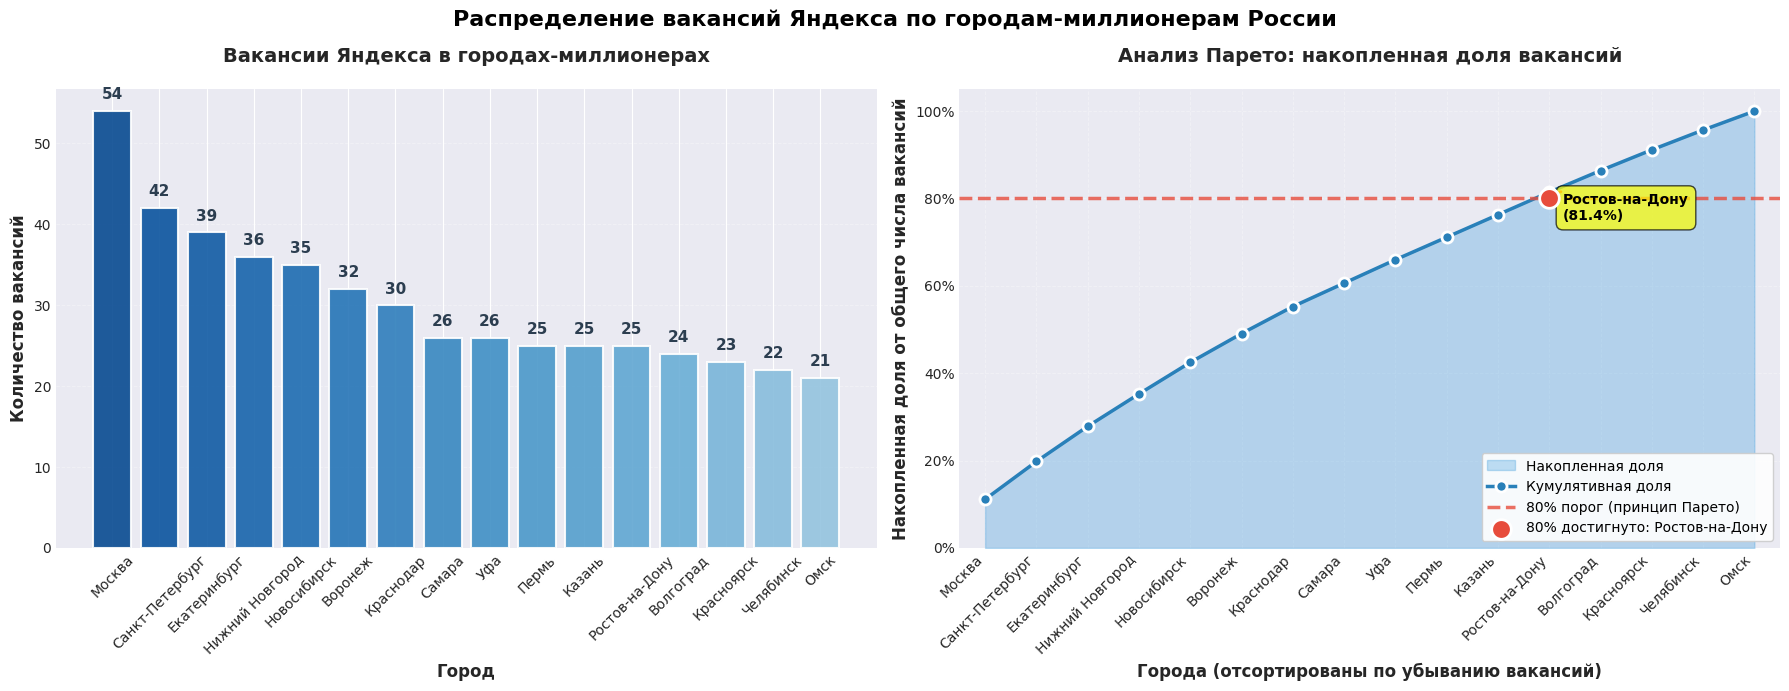


СТАТИСТИКА РАСПРЕДЕЛЕНИЯ ВАКАНСИЙ

Топ-3 города по количеству вакансий:
  1. Москва: 54 (11.1%)
  2. Санкт-Петербург: 42 (8.7%)
  3. Екатеринбург: 39 (8.0%)

Принцип Парето (80/20):
  12 город(ов) из 16 (75.0%) содержат 80% вакансий

Общее количество вакансий: 485
Средняя концентрация: 30.3 вакансий на город
Медиана: 26.0


In [85]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# Проверка наличия данных
if 'yandex_city_vacancies_df' not in globals():
    raise ValueError("Сначала выполните ячейку задания 16, чтобы получить yandex_city_vacancies_df")

# Подготовка данных
viz_df = (
    yandex_city_vacancies_df[yandex_city_vacancies_df["area_name"] != "Total"]
    .copy()
    .sort_values("vacancy_cnt", ascending=False)
)

# Создание фигуры с увеличенным размером
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Настройка общего стиля
plt.style.use('default')

# ===== График 1: Столбчатая диаграмма =====
# Градиентная цветовая схема от тёмного к светлому
colors_gradient = plt.cm.Blues(np.linspace(0.9, 0.4, len(viz_df)))

bars = axes[0].bar(viz_df["area_name"], 
                    viz_df["vacancy_cnt"], 
                    color=colors_gradient,
                    edgecolor='white',
                    linewidth=1.5,
                    alpha=0.9)

# Добавляем значения на столбцы
for i, (bar, value) in enumerate(zip(bars, viz_df["vacancy_cnt"])):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2., 
                 height + max(viz_df["vacancy_cnt"]) * 0.02,
                 f'{int(value)}',
                 ha='center', 
                 va='bottom',
                 fontsize=11,
                 fontweight='bold',
                 color='#2c3e50')

axes[0].set_title("Вакансии Яндекса в городах-миллионерах", 
                  fontsize=14, fontweight='bold', pad=20)
axes[0].set_xlabel("Город", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Количество вакансий", fontsize=12, fontweight='bold')
axes[0].tick_params(axis="x", rotation=45, labelsize=10)
axes[0].tick_params(axis="y", labelsize=10)

# Форматирование оси Y с разделителями тысяч
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x):,}'))

# Добавляем сетку
axes[0].grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)
axes[0].set_axisbelow(True)

# Убираем верхнюю и правую границы
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# ===== График 2: Кумулятивная доля (принцип Парето) =====
# Вычисляем доли
share_df = viz_df.copy()
share_df["share"] = share_df["vacancy_cnt"] / share_df["vacancy_cnt"].sum()
share_df["cum_share"] = share_df["share"].cumsum()

# Основная линия с заливкой
axes[1].fill_between(range(len(share_df)), 
                      share_df["cum_share"], 
                      alpha=0.3, 
                      color='#3498db',
                      label='Накопленная доля')

# Линия тренда
line = axes[1].plot(range(len(share_df)), 
                    share_df["cum_share"], 
                    marker='o', 
                    markersize=8,
                    color='#2980b9',
                    linewidth=2.5,
                    markeredgecolor='white',
                    markeredgewidth=2,
                    label='Кумулятивная доля')

# Линия 80% порога (принцип Парето)
axes[1].axhline(0.8, 
                color='#e74c3c', 
                linestyle='--', 
                linewidth=2.5, 
                label='80% порог (принцип Парето)',
                alpha=0.8)

# Находим точку пересечения 80%
pareto_index = (share_df["cum_share"] >= 0.8).idxmax()
pareto_position = share_df.index.get_loc(pareto_index)
pareto_city = share_df.loc[pareto_index, "area_name"]

# Выделяем точку пересечения
axes[1].scatter([pareto_position], 
                [0.8], 
                color='#e74c3c', 
                s=200, 
                zorder=5,
                edgecolor='white',
                linewidth=2,
                label=f'80% достигнуто: {pareto_city}')

# Добавляем аннотацию к точке пересечения
axes[1].annotate(f'{pareto_city}\n({share_df.loc[pareto_index, "cum_share"]*100:.1f}%)',
                 xy=(pareto_position, share_df.loc[pareto_index, "cum_share"]),
                 xytext=(10, -20),
                 textcoords='offset points',
                 fontsize=10,
                 fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', 
                                color='#e74c3c', lw=2))

# Настройка осей
axes[1].set_xlim(-0.5, len(share_df) - 0.5)
axes[1].set_ylim(0, 1.05)
axes[1].set_title("Анализ Парето: накопленная доля вакансий", 
                  fontsize=14, fontweight='bold', pad=20)
axes[1].set_xlabel("Города (отсортированы по убыванию вакансий)", 
                   fontsize=12, fontweight='bold')
axes[1].set_ylabel("Накопленная доля от общего числа вакансий", 
                   fontsize=12, fontweight='bold')

# Устанавливаем метки городов на оси X
axes[1].set_xticks(range(len(share_df)))
axes[1].set_xticklabels(share_df["area_name"], rotation=45, ha='right', fontsize=10)

# Форматируем ось Y в проценты
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

# Сетка
axes[1].grid(axis='both', alpha=0.3, linestyle='--', linewidth=0.7)
axes[1].set_axisbelow(True)

# Легенда
axes[1].legend(loc='lower right', fontsize=10, framealpha=0.9)

# Убираем верхнюю и правую границы
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Общий заголовок
plt.suptitle("Распределение вакансий Яндекса по городам-миллионерам России", 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# Вывод дополнительной статистики
print("\n" + "="*60)
print("СТАТИСТИКА РАСПРЕДЕЛЕНИЯ ВАКАНСИЙ")
print("="*60)
print(f"\nТоп-3 города по количеству вакансий:")
for idx, (_, row) in enumerate(viz_df.head(3).iterrows(), 1):
    print(f"  {idx}. {row['area_name']}: {int(row['vacancy_cnt'])} "
          f"({row['vacancy_cnt']/viz_df['vacancy_cnt'].sum()*100:.1f}%)")

print(f"\nПринцип Парето (80/20):")
print(f"  {pareto_position + 1} город(ов) из {len(viz_df)} "
      f"({(pareto_position + 1)/len(viz_df)*100:.1f}%) содержат 80% вакансий")

total_vacancies = viz_df['vacancy_cnt'].sum()
print(f"\nОбщее количество вакансий: {int(total_vacancies)}")
print(f"Средняя концентрация: {viz_df['vacancy_cnt'].mean():.1f} вакансий на город")
print(f"Медиана: {viz_df['vacancy_cnt'].median():.1f}")


In [43]:
# выводы по анализу работодателей

### Выводы по анализу работодателей

На основании проведённого анализа и сформированных запросов можно сделать следующие выводы:

**Лидер по числу размещённых вакансий — компания «Яндекс»**, обладающая **1 933 вакансиями**. На втором месте — **«Ростелеком»** с **1 740 вакансиями**.

**Распределение вакансий Яндекса по городам-миллионникам** показывает высокую концентрацию в крупнейших центрах:
- **Москва** — 54 вакансии (11.1% от общего объёма)
- **Санкт-Петербург** — 42 вакансии (8.7%)
- **Екатеринбург** — 39 вакансий (8.0%)

Общее количество вакансий, размещённых Яндексом в городах-миллионниках, составляет **485**.

**График Парето** демонстрирует, что **80%** всех вакансий сосредоточены в **12 городах**.  
**Критический порог** (80%) достигается в **Ростове-на-Дону**, где накопленная доля вакансий составляет **81.4%**, что подтверждает **принцип Парето**.


## 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

    Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова `'data'` или `'данн'`.

    *Обратите внимание, что названия вакансий могут быть написаны в любом регистре.*


In [86]:
# текст запроса
data_keywords = [
    "%данн%",  # русскоязычные вхождения (данные, аналитик данных и т.д.)
    "%data%"   # англоязычные вхождения
]

def detect_column(full_table_name, candidates):
    schema_name, table_name = full_table_name.split('.', 1)
    column_lookup_query = f"""
        select column_name
        from information_schema.columns
        where table_schema = '{schema_name}'
          and table_name   = '{table_name}'
    """
    columns_df = pd.read_sql_query(column_lookup_query, connection)
    if columns_df.empty:
        raise ValueError(f"Не удалось получить столбцы для таблицы {full_table_name}")
    available = {col.lower(): col for col in columns_df["column_name"]}
    for candidate in candidates:
        if candidate.lower() in available:
            return available[candidate.lower()]
    raise ValueError(f"Не найден нужный столбец среди {candidates} в таблице {full_table_name}")

vacancies_lookup_query = """
    select table_schema || '.' || table_name as full_name
    from information_schema.tables
    where table_name = 'vacancies'
      and table_schema not in ('pg_catalog', 'information_schema')
    order by full_name
"""
vacancies_tables = pd.read_sql_query(vacancies_lookup_query, connection)
if vacancies_tables.empty:
    raise ValueError("Таблица vacancies не найдена в пользовательских схемах базы")
vacancies_table = vacancies_tables.loc[0, "full_name"]

vacancy_name_column = detect_column(vacancies_table, ["name", "title", "vacancy_name"])

pattern_conditions = []
pattern_params = {}
for idx, pattern in enumerate(data_keywords):
    param_name = f"pattern_{idx}"
    pattern_conditions.append(f"v.{vacancy_name_column} ILIKE %({param_name})s")
    pattern_params[param_name] = pattern

if not pattern_conditions:
    raise ValueError("Не заданы шаблоны для поиска вакансий, связанных с данными")

where_clause = " OR ".join(pattern_conditions)

data_related_vacancies_query = f"""
    with data_vacancies as (
        select distinct v.id
        from {vacancies_table} v
        where v.{vacancy_name_column} is not null
          and ({where_clause})
    )
    select count(*) as data_related_vacancy_cnt
    from data_vacancies
"""



/tmp/ipykernel_3433801/2007539048.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  vacancies_tables = pd.read_sql_query(vacancies_lookup_query, connection)
/tmp/ipykernel_3433801/2007539048.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  columns_df = pd.read_sql_query(column_lookup_query, connection)


In [87]:
# результат запроса
data_related_vacancies_df = pd.read_sql_query(
    data_related_vacancies_query,
    connection,
    params=pattern_params
)
data_related_vacancies_df

/tmp/ipykernel_3433801/2050749774.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_related_vacancies_df = pd.read_sql_query(


,data_related_vacancy_cnt
0,1771


2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
    * 'data scientist'
    * 'data science'
    * 'исследователь данных'
    * 'ML' (здесь не нужно брать вакансии по HTML)
    * 'machine learning'
    * 'машинн%обучен%'

    **В следующих заданиях мы продолжим работать с вакансиями по этому условию.**

    Считаем вакансиями для специалистов уровня Junior следующие:
    + в названии есть слово “junior” **или**
    + требуемый опыт — «Нет опыта» **или**
    + тип трудоустройства — «Стажировка».


In [88]:
# текст запроса

data_science_like_patterns = [
    "%data scientist%",
    "%data science%",
    "%исследователь данных%",
    "%machine learning%",
    "%машинн%обучен%"
]
ml_boundary_regex = r"(^|[^a-zA-Z0-9])ml([^a-zA-Z0-9]|$)"  # избегаем HTML, требуя отдельное слово ML

def detect_column(full_table_name, candidates):
    schema_name, table_name = full_table_name.split('.', 1)
    column_lookup_query = f"""
        select column_name
        from information_schema.columns
        where table_schema = '{schema_name}'
          and table_name   = '{table_name}'
    """
    columns_df = pd.read_sql_query(column_lookup_query, connection)
    if columns_df.empty:
        raise ValueError(f"Не удалось получить столбцы для таблицы {full_table_name}")
    available = {col.lower(): col for col in columns_df["column_name"]}
    for candidate in candidates:
        if candidate.lower() in available:
            return available[candidate.lower()]
    return None

vacancies_lookup_query = """
    select table_schema || '.' || table_name as full_name
    from information_schema.tables
    where table_name = 'vacancies'
      and table_schema not in ('pg_catalog', 'information_schema')
    order by full_name
"""
vacancies_tables = pd.read_sql_query(vacancies_lookup_query, connection)
if vacancies_tables.empty:
    raise ValueError("Таблица vacancies не найдена в пользовательских схемах базы")
vacancies_table = vacancies_tables.loc[0, "full_name"]

vacancy_name_column = detect_column(vacancies_table, ["name", "title", "vacancy_name"])
if not vacancy_name_column:
    raise ValueError("Не найден столбец с названием вакансии в таблице vacancies")
experience_column = detect_column(vacancies_table, ["experience", "experience_name", "exp", "experience_level"])
employment_column = detect_column(vacancies_table, ["employment", "employment_type", "employment_name"])

data_conditions = []
data_params = {}
for idx, pattern in enumerate(data_science_like_patterns):
    param_name = f"data_pattern_{idx}"
    data_conditions.append(f"v.{vacancy_name_column} ILIKE %({param_name})s")
    data_params[param_name] = pattern
data_conditions.append(f"v.{vacancy_name_column} ~* %(ml_boundary_pattern)s")
data_params["ml_boundary_pattern"] = ml_boundary_regex

junior_conditions = []
junior_params = {}
junior_conditions.append(f"v.{vacancy_name_column} ILIKE %(junior_keyword)s")
junior_params["junior_keyword"] = "%junior%"
if experience_column:
    junior_conditions.append(f"lower(v.{experience_column}) = lower(%(no_experience_label)s)")
    junior_params["no_experience_label"] = "Нет опыта"
if employment_column:
    junior_conditions.append(f"lower(v.{employment_column}) = lower(%(internship_label)s)")
    junior_params["internship_label"] = "Стажировка"

if not data_conditions:
    raise ValueError("Не заданы условия для поиска data science вакансий")
if not junior_conditions:
    raise ValueError("Не заданы условия для отбора junior вакансий")

data_condition_sql = " OR ".join(f"({cond})" for cond in data_conditions)
junior_condition_sql = " OR ".join(f"({cond})" for cond in junior_conditions)

junior_data_science_query = f"""
    with filtered_vacancies as (
        select distinct v.id
        from {vacancies_table} v
        where v.{vacancy_name_column} is not null
          and ({data_condition_sql})
          and ({junior_condition_sql})
    )
    select count(*) as junior_data_science_vacancy_cnt
    from filtered_vacancies
"""


/tmp/ipykernel_3433801/365952102.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  vacancies_tables = pd.read_sql_query(vacancies_lookup_query, connection)
/tmp/ipykernel_3433801/365952102.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  columns_df = pd.read_sql_query(column_lookup_query, connection)


In [89]:
# результат запроса

query_params = {**data_params, **junior_params}
junior_data_science_df = pd.read_sql_query(
    junior_data_science_query,
    connection,
    params=query_params
)
junior_data_science_df

/tmp/ipykernel_3433801/399702714.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  junior_data_science_df = pd.read_sql_query(


,junior_data_science_vacancy_cnt
0,51


3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или Postgres?

    *Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [90]:
# текст запроса
data_science_like_patterns = [
    "%data scientist%",
    "%data science%",
    "%исследователь данных%",
    "%machine learning%",
    "%машинн%обучен%"
]
ml_boundary_regex = r"(^|[^a-zA-Z0-9])ml([^a-zA-Z0-9]|$)"
skill_keywords = ["%SQL%", "%Postgres%"]

def detect_column(full_table_name, candidates):
    schema_name, table_name = full_table_name.split('.', 1)
    column_lookup_query = f"""
        select column_name
        from information_schema.columns
        where table_schema = '{schema_name}'
          and table_name   = '{table_name}'
    """
    columns_df = pd.read_sql_query(column_lookup_query, connection)
    if columns_df.empty:
        raise ValueError(f"Не удалось получить столбцы для таблицы {full_table_name}")
    available = {col.lower(): col for col in columns_df["column_name"]}
    for candidate in candidates:
        if candidate.lower() in available:
            return available[candidate.lower()]
    raise ValueError(f"Не найден нужный столбец среди {candidates} в таблице {full_table_name}")

def try_find_table(preferred_names):
    for name in preferred_names:
        table_lookup_query = f"""
            select table_schema || '.' || table_name as full_name
            from information_schema.tables
            where lower(table_name) = lower('{name}')
              and table_schema not in ('pg_catalog', 'information_schema')
            order by full_name
        """
        tables_df = pd.read_sql_query(table_lookup_query, connection)
        if not tables_df.empty:
            return tables_df.loc[0, "full_name"]
    return None

def list_user_tables():
    query = """
        select table_schema || '.' || table_name as full_name
        from information_schema.tables
        where table_schema not in ('pg_catalog', 'information_schema')
        order by full_name
    """
    return pd.read_sql_query(query, connection)

vacancies_table = try_find_table(["vacancies"])
if not vacancies_table:
    raise ValueError("Таблица vacancies не найдена в пользовательских схемах базы")

vacancy_name_column = detect_column(vacancies_table, ["name", "title", "vacancy_name"])

vacancy_key_skills_column = None
try:
    vacancy_key_skills_column = detect_column(vacancies_table, ["key_skills", "skills", "key_skill_list", "key_skill"])
except ValueError:
    vacancy_key_skills_column = None

skill_source_type = None  # inline, linked_text, linked_id
inline_skill_column = None
vacancy_skills_table = None
skill_vacancy_column = None
skill_value_column = None
skill_id_column = None
skills_lookup_table = None
skills_lookup_id_column = None
skills_lookup_name_column = None

if vacancy_key_skills_column:
    skill_source_type = "inline"
    inline_skill_column = vacancy_key_skills_column
else:
    user_tables_df = list_user_tables()
    for full_table_name in user_tables_df["full_name"]:
        if full_table_name == vacancies_table:
            continue
        try:
            vacancy_col_candidate = detect_column(full_table_name, ["vacancy_id", "vacancies_id", "vacancy", "vac_id"])
        except ValueError:
            continue
        # сначала пробуем найти текст навыка в той же таблице
        try:
            skill_col_candidate = detect_column(full_table_name, ["skill_name", "skill", "key_skill", "skill_title", "skill_value"])
            skill_source_type = "linked_text"
            vacancy_skills_table = full_table_name
            skill_vacancy_column = vacancy_col_candidate
            skill_value_column = skill_col_candidate
            break
        except ValueError:
            pass
        # если текстового столбца нет, ищем идентификатор навыка и отдельный справочник
        try:
            skill_col_candidate = detect_column(full_table_name, ["skill_id", "key_skill_id", "skills_id", "skill"])
            candidate_lookup_table = try_find_table(["skills", "skill", "key_skills", "skills_dictionary"])
            if not candidate_lookup_table:
                continue
            lookup_id_column = detect_column(candidate_lookup_table, ["id", "skill_id"])
            lookup_name_column = detect_column(candidate_lookup_table, ["name", "skill_name", "title"])
            skill_source_type = "linked_id"
            vacancy_skills_table = full_table_name
            skill_vacancy_column = vacancy_col_candidate
            skill_id_column = skill_col_candidate
            skills_lookup_table = candidate_lookup_table
            skills_lookup_id_column = lookup_id_column
            skills_lookup_name_column = lookup_name_column
            break
        except ValueError:
            continue

if not skill_source_type:
    raise ValueError("Не удалось определить источник ключевых навыков для вакансий")

data_conditions = []
data_params = {}
for idx, pattern in enumerate(data_science_like_patterns):
    param_name = f"data_pattern_{idx}"
    data_conditions.append(f"v.{vacancy_name_column} ILIKE %({param_name})s")
    data_params[param_name] = pattern
data_conditions.append(f"v.{vacancy_name_column} ~* %(ml_boundary_pattern)s")
data_params["ml_boundary_pattern"] = ml_boundary_regex
data_condition_sql = " OR ".join(f"({cond})" for cond in data_conditions)

skill_params = {}
skill_param_names = []
for idx, pattern in enumerate(skill_keywords):
    param_name = f"skill_pattern_{idx}"
    skill_param_names.append(param_name)
    skill_params[param_name] = pattern

if skill_source_type == "inline":
    skill_clause_sql = " OR ".join(
        f"(v.{inline_skill_column} ILIKE %({param})s)" for param in skill_param_names
    )
    ds_sql_skills_query = f"""
        select count(distinct v.id) as ds_with_sql_skill_cnt
        from {vacancies_table} v
        where v.{vacancy_name_column} is not null
          and ({data_condition_sql})
          and v.{inline_skill_column} is not null
          and ({skill_clause_sql})
    """
elif skill_source_type == "linked_text":
    skill_clause_sql = " OR ".join(
        f"(vs.{skill_value_column} ILIKE %({param})s)" for param in skill_param_names
    )
    ds_sql_skills_query = f"""
        with data_science_vacancies as (
            select distinct v.id
            from {vacancies_table} v
            where v.{vacancy_name_column} is not null
              and ({data_condition_sql})
        ),
        skill_matches as (
            select distinct vs.{skill_vacancy_column} as vacancy_id
            from {vacancy_skills_table} vs
            where vs.{skill_vacancy_column} is not null
              and vs.{skill_value_column} is not null
              and ({skill_clause_sql})
        )
        select count(*) as ds_with_sql_skill_cnt
        from data_science_vacancies dsv
        join skill_matches sm
          on sm.vacancy_id = dsv.id
    """
else:  # linked_id
    skill_clause_sql = " OR ".join(
        f"(s.{skills_lookup_name_column} ILIKE %({param})s)" for param in skill_param_names
    )
    ds_sql_skills_query = f"""
        with data_science_vacancies as (
            select distinct v.id
            from {vacancies_table} v
            where v.{vacancy_name_column} is not null
              and ({data_condition_sql})
        ),
        skill_matches as (
            select distinct vs.{skill_vacancy_column} as vacancy_id
            from {vacancy_skills_table} vs
            join {skills_lookup_table} s
              on s.{skills_lookup_id_column} = vs.{skill_id_column}
            where vs.{skill_vacancy_column} is not null
              and s.{skills_lookup_name_column} is not null
              and ({skill_clause_sql})
        )
        select count(*) as ds_with_sql_skill_cnt
        from data_science_vacancies dsv
        join skill_matches sm
          on sm.vacancy_id = dsv.id
    """

/tmp/ipykernel_3433801/4031271893.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tables_df = pd.read_sql_query(table_lookup_query, connection)
/tmp/ipykernel_3433801/4031271893.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  columns_df = pd.read_sql_query(column_lookup_query, connection)


In [91]:
# результат запроса

query_params = {**data_params, **skill_params}
ds_sql_skills_df = pd.read_sql_query(
    ds_sql_skills_query,
    connection,
    params=query_params
)
ds_sql_skills_df

/tmp/ipykernel_3433801/2748461287.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ds_sql_skills_df = pd.read_sql_query(


,ds_with_sql_skill_cnt
0,195


4. Проверьте, насколько популярен Python в требованиях работодателей к DS. Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

    *Это можно сделать помощью запроса, аналогичного предыдущему.*

In [92]:
# текст запроса
data_science_like_patterns = [
    "%data scientist%",
    "%data science%",
    "%исследователь данных%",
    "%machine learning%",
    "%машинн%обучен%"
]
ml_boundary_regex = r"(^|[^a-zA-Z0-9])ml([^a-zA-Z0-9]|$)"
python_skill_patterns = ["%python%"]

def detect_column(full_table_name, candidates):
    schema_name, table_name = full_table_name.split('.', 1)
    column_lookup_query = f"""
        select column_name
        from information_schema.columns
        where table_schema = '{schema_name}'
          and table_name   = '{table_name}'
    """
    columns_df = pd.read_sql_query(column_lookup_query, connection)
    if columns_df.empty:
        raise ValueError(f"Не удалось получить столбцы для таблицы {full_table_name}")
    available = {col.lower(): col for col in columns_df["column_name"]}
    for candidate in candidates:
        if candidate.lower() in available:
            return available[candidate.lower()]
    raise ValueError(f"Не найден столбец среди {candidates} в таблице {full_table_name}")

def try_find_table(preferred_names):
    for name in preferred_names:
        table_lookup_query = f"""
            select table_schema || '.' || table_name as full_name
            from information_schema.tables
            where lower(table_name) = lower('{name}')
              and table_schema not in ('pg_catalog', 'information_schema')
            order by full_name
        """
        tables_df = pd.read_sql_query(table_lookup_query, connection)
        if not tables_df.empty:
            return tables_df.loc[0, "full_name"]
    return None

def list_user_tables():
    user_tables_query = """
        select table_schema || '.' || table_name as full_name
        from information_schema.tables
        where table_schema not in ('pg_catalog', 'information_schema')
        order by full_name
    """
    return pd.read_sql_query(user_tables_query, connection)

vacancies_table = try_find_table(["vacancies"])
if not vacancies_table:
    raise ValueError("Таблица vacancies не найдена в пользовательских схемах базы")

vacancy_name_column = detect_column(vacancies_table, ["name", "title", "vacancy_name"])

vacancy_key_skills_column = None
try:
    vacancy_key_skills_column = detect_column(vacancies_table, ["key_skills", "skills", "key_skill_list", "key_skill"])
except ValueError:
    vacancy_key_skills_column = None

skill_source_type = None  # inline, linked_text, linked_id
inline_skill_column = None
vacancy_skills_table = None
skill_vacancy_column = None
skill_value_column = None
skill_id_column = None
skills_lookup_table = None
skills_lookup_id_column = None
skills_lookup_name_column = None

if vacancy_key_skills_column:
    skill_source_type = "inline"
    inline_skill_column = vacancy_key_skills_column
else:
    user_tables_df = list_user_tables()
    for full_table_name in user_tables_df["full_name"]:
        if full_table_name == vacancies_table:
            continue
        try:
            vacancy_col_candidate = detect_column(full_table_name, ["vacancy_id", "vacancies_id", "vacancy", "vac_id"])
        except ValueError:
            continue
        try:
            skill_col_candidate = detect_column(full_table_name, ["skill_name", "skill", "key_skill", "skill_title", "skill_value"])
            skill_source_type = "linked_text"
            vacancy_skills_table = full_table_name
            skill_vacancy_column = vacancy_col_candidate
            skill_value_column = skill_col_candidate
            break
        except ValueError:
            pass
        try:
            skill_col_candidate = detect_column(full_table_name, ["skill_id", "key_skill_id", "skills_id", "skill"])
            candidate_lookup_table = try_find_table(["skills", "skill", "key_skills", "skills_dictionary"])
            if not candidate_lookup_table:
                continue
            lookup_id_column = detect_column(candidate_lookup_table, ["id", "skill_id"])
            lookup_name_column = detect_column(candidate_lookup_table, ["name", "skill_name", "title"])
            skill_source_type = "linked_id"
            vacancy_skills_table = full_table_name
            skill_vacancy_column = vacancy_col_candidate
            skill_id_column = skill_col_candidate
            skills_lookup_table = candidate_lookup_table
            skills_lookup_id_column = lookup_id_column
            skills_lookup_name_column = lookup_name_column
            break
        except ValueError:
            continue

if not skill_source_type:
    raise ValueError("Не удалось определить источник ключевых навыков для вакансий")

data_conditions = []
data_params = {}
for idx, pattern in enumerate(data_science_like_patterns):
    param_name = f"data_pattern_{idx}"
    data_conditions.append(f"v.{vacancy_name_column} ILIKE %({param_name})s")
    data_params[param_name] = pattern
data_conditions.append(f"v.{vacancy_name_column} ~* %(ml_boundary_pattern)s")
data_params["ml_boundary_pattern"] = ml_boundary_regex
data_condition_sql = " OR ".join(f"({cond})" for cond in data_conditions)

skill_params = {}
skill_param_names = []
for idx, pattern in enumerate(python_skill_patterns):
    param_name = f"python_pattern_{idx}"
    skill_param_names.append(param_name)
    skill_params[param_name] = pattern

if skill_source_type == "inline":
    skill_clause_sql = " OR ".join(
        f"(v.{inline_skill_column} ILIKE %({param})s)" for param in skill_param_names
    )
    ds_python_skills_query = f"""
        select count(distinct v.id) as ds_with_python_skill_cnt
        from {vacancies_table} v
        where v.{vacancy_name_column} is not null
          and ({data_condition_sql})
          and v.{inline_skill_column} is not null
          and ({skill_clause_sql})
    """
elif skill_source_type == "linked_text":
    skill_clause_sql = " OR ".join(
        f"(vs.{skill_value_column} ILIKE %({param})s)" for param in skill_param_names
    )
    ds_python_skills_query = f"""
        with data_science_vacancies as (
            select distinct v.id
            from {vacancies_table} v
            where v.{vacancy_name_column} is not null
              and ({data_condition_sql})
        ),
        skill_matches as (
            select distinct vs.{skill_vacancy_column} as vacancy_id
            from {vacancy_skills_table} vs
            where vs.{skill_vacancy_column} is not null
              and vs.{skill_value_column} is not null
              and ({skill_clause_sql})
        )
        select count(*) as ds_with_python_skill_cnt
        from data_science_vacancies dsv
        join skill_matches sm
          on sm.vacancy_id = dsv.id
    """
else:  # linked_id
    skill_clause_sql = " OR ".join(
        f"(s.{skills_lookup_name_column} ILIKE %({param})s)" for param in skill_param_names
    )
    ds_python_skills_query = f"""
        with data_science_vacancies as (
            select distinct v.id
            from {vacancies_table} v
            where v.{vacancy_name_column} is not null
              and ({data_condition_sql})
        ),
        skill_matches as (
            select distinct vs.{skill_vacancy_column} as vacancy_id
            from {vacancy_skills_table} vs
            join {skills_lookup_table} s
              on s.{skills_lookup_id_column} = vs.{skill_id_column}
            where vs.{skill_vacancy_column} is not null
              and s.{skills_lookup_name_column} is not null
              and ({skill_clause_sql})
        )
        select count(*) as ds_with_python_skill_cnt
        from data_science_vacancies dsv
        join skill_matches sm
          on sm.vacancy_id = dsv.id
    """

/tmp/ipykernel_3433801/2374780442.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tables_df = pd.read_sql_query(table_lookup_query, connection)
/tmp/ipykernel_3433801/2374780442.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  columns_df = pd.read_sql_query(column_lookup_query, connection)


In [93]:
# результат запроса
query_params = {**data_params, **skill_params}
ds_python_skills_df = pd.read_sql_query(
    ds_python_skills_query,
    connection,
    params=query_params
)
ds_python_skills_df

/tmp/ipykernel_3433801/3563204896.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ds_python_skills_df = pd.read_sql_query(


,ds_with_python_skill_cnt
0,344


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до **двух знаков после точки-разделителя**.

In [94]:
# текст запроса
data_science_like_patterns = [
    "%data scientist%",
    "%data science%",
    "%исследователь данных%",
    "%machine learning%",
    "%машинн%обучен%"
]
ml_boundary_regex = r"(^|[^a-zA-Z0-9])ml([^a-zA-Z0-9]|$)"

def detect_column(full_table_name, candidates):
    schema_name, table_name = full_table_name.split('.', 1)
    column_lookup_query = f"""
        select column_name
        from information_schema.columns
        where table_schema = '{schema_name}'
          and table_name   = '{table_name}'
    """
    columns_df = pd.read_sql_query(column_lookup_query, connection)
    if columns_df.empty:
        raise ValueError(f"Не удалось получить столбцы для таблицы {full_table_name}")
    available = {col.lower(): col for col in columns_df["column_name"]}
    for candidate in candidates:
        if candidate.lower() in available:
            return available[candidate.lower()]
    raise ValueError(f"Не найден столбец среди {candidates} в таблице {full_table_name}")

def try_find_table(preferred_names):
    for name in preferred_names:
        table_lookup_query = f"""
            select table_schema || '.' || table_name as full_name
            from information_schema.tables
            where lower(table_name) = lower('{name}')
              and table_schema not in ('pg_catalog', 'information_schema')
            order by full_name
        """
        tables_df = pd.read_sql_query(table_lookup_query, connection)
        if not tables_df.empty:
            return tables_df.loc[0, "full_name"]
    return None

def list_user_tables():
    tables_query = """
        select table_schema || '.' || table_name as full_name
        from information_schema.tables
        where table_schema not in ('pg_catalog', 'information_schema')
        order by full_name
    """
    return pd.read_sql_query(tables_query, connection)

vacancies_table = try_find_table(["vacancies"])
if not vacancies_table:
    raise ValueError("Таблица vacancies не найдена в пользовательских схемах базы")

vacancy_name_column = detect_column(vacancies_table, ["name", "title", "vacancy_name"])

vacancy_key_skills_column = None
try:
    vacancy_key_skills_column = detect_column(vacancies_table, ["key_skills", "skills", "key_skill_list", "key_skill"])
except ValueError:
    vacancy_key_skills_column = None

skill_source_type = None  # inline, linked_text, linked_id
inline_skill_column = None
vacancy_skills_table = None
skill_vacancy_column = None
skill_value_column = None
skill_id_column = None
skills_lookup_table = None
skills_lookup_id_column = None
skills_lookup_name_column = None

if vacancy_key_skills_column:
    skill_source_type = "inline"
    inline_skill_column = vacancy_key_skills_column
else:
    user_tables_df = list_user_tables()
    for full_table_name in user_tables_df["full_name"]:
        if full_table_name == vacancies_table:
            continue
        try:
            vacancy_col_candidate = detect_column(full_table_name, ["vacancy_id", "vacancies_id", "vacancy", "vac_id"])
        except ValueError:
            continue
        try:
            skill_col_candidate = detect_column(full_table_name, ["skill_name", "skill", "key_skill", "skill_title", "skill_value"])
            skill_source_type = "linked_text"
            vacancy_skills_table = full_table_name
            skill_vacancy_column = vacancy_col_candidate
            skill_value_column = skill_col_candidate
            break
        except ValueError:
            pass
        try:
            skill_col_candidate = detect_column(full_table_name, ["skill_id", "key_skill_id", "skills_id", "skill"])
            candidate_lookup_table = try_find_table(["skills", "skill", "key_skills", "skills_dictionary"])
            if not candidate_lookup_table:
                continue
            lookup_id_column = detect_column(candidate_lookup_table, ["id", "skill_id"])
            lookup_name_column = detect_column(candidate_lookup_table, ["name", "skill_name", "title"])
            skill_source_type = "linked_id"
            vacancy_skills_table = full_table_name
            skill_vacancy_column = vacancy_col_candidate
            skill_id_column = skill_col_candidate
            skills_lookup_table = candidate_lookup_table
            skills_lookup_id_column = lookup_id_column
            skills_lookup_name_column = lookup_name_column
            break
        except ValueError:
            continue

if not skill_source_type:
    raise ValueError("Не удалось определить источник ключевых навыков для вакансий")

data_conditions = []
for idx, pattern in enumerate(data_science_like_patterns):
    param_name = f"data_pattern_{idx}"
    data_conditions.append(f"v.{vacancy_name_column} ILIKE %({param_name})s")

data_conditions.append(f"v.{vacancy_name_column} ~* %(ml_boundary_pattern)s")
data_condition_sql = " OR ".join(f"({cond})" for cond in data_conditions)

params = {f"data_pattern_{idx}": pattern for idx, pattern in enumerate(data_science_like_patterns)}
params["ml_boundary_pattern"] = ml_boundary_regex

if skill_source_type == "inline":
    avg_skills_query = f"""
        with data_science_vacancies as (
            select distinct v.id, v.{inline_skill_column}
            from {vacancies_table} v
            where v.{vacancy_name_column} is not null
              and ({data_condition_sql})
        ),
        vacancy_skill_counts as (
            select id as vacancy_id,
                   case
                       when {inline_skill_column} is null or trim({inline_skill_column}) = '' then 0
                       else array_length(regexp_split_to_array({inline_skill_column}, '\\s*,\\s*'), 1)
                   end as skill_cnt
            from data_science_vacancies
        )
        select round(avg(skill_cnt)::numeric, 2) as avg_key_skill_cnt
        from vacancy_skill_counts
    """
elif skill_source_type == "linked_text":
    avg_skills_query = f"""
        with data_science_vacancies as (
            select distinct v.id
            from {vacancies_table} v
            where v.{vacancy_name_column} is not null
              and ({data_condition_sql})
        ),
        skill_counts as (
            select dsv.id as vacancy_id,
                   count(distinct vs.{skill_value_column}) as skill_cnt
            from data_science_vacancies dsv
            left join {vacancy_skills_table} vs
              on vs.{skill_vacancy_column} = dsv.id
             and vs.{skill_value_column} is not null
            group by dsv.id
        )
        select round(avg(skill_cnt)::numeric, 2) as avg_key_skill_cnt
        from skill_counts
    """
else:  # linked_id
    avg_skills_query = f"""
        with data_science_vacancies as (
            select distinct v.id
            from {vacancies_table} v
            where v.{vacancy_name_column} is not null
              and ({data_condition_sql})
        ),
        skill_counts as (
            select dsv.id as vacancy_id,
                   count(distinct s.{skills_lookup_id_column}) as skill_cnt
            from data_science_vacancies dsv
            left join {vacancy_skills_table} vs
              on vs.{skill_vacancy_column} = dsv.id
            left join {skills_lookup_table} s
              on s.{skills_lookup_id_column} = vs.{skill_id_column}
            where s.{skills_lookup_name_column} is not null
            group by dsv.id
        )
        select round(avg(skill_cnt)::numeric, 2) as avg_key_skill_cnt
        from skill_counts
    """



/tmp/ipykernel_3433801/351267781.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tables_df = pd.read_sql_query(table_lookup_query, connection)
/tmp/ipykernel_3433801/351267781.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  columns_df = pd.read_sql_query(column_lookup_query, connection)


In [95]:
# результат запроса
ds_avg_skill_df = pd.read_sql_query(
    avg_skills_query,
    connection,
    params=params
)
ds_avg_skill_df

/tmp/ipykernel_3433801/3569797631.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ds_avg_skill_df = pd.read_sql_query(


,avg_key_skill_cnt
0,0.98


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в среднем указывают для каждого типа требуемого опыта (уникальное значение из поля `experience`).

    При решении задачи примите во внимание следующее:
    1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
    2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
    3. Если в расчётах участвует `null`, в результате он тоже даст `null` (посмотрите, что возвращает запрос `select 1 + null`). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит `null` на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

    Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до **целого числа**.

In [54]:
# текст запроса

In [55]:
# результат запроса

***

In [56]:
# выводы по предметному анализу

## Общий вывод по проекту

In [ ]:
# подведем итог исследования, обобщите выводы
# здесь можно (это будет плюсом) провести дополнительные исследования данных, сделать прогнозы, продумать варианты продолжения исследования

# Итоговый анализ и обобщение выводов

Общее количество вакансий в исследуемой базе данных составляет **49 197**.  
На основе детального анализа можно сделать следующие ключевые выводы:

---

### **Тип вакансий: доминирующие категории**

Наиболее востребованными являются **вакансии полной занятости (на полный рабочий день)** — **35 367** (составляют **71%** от общего числа).  
Второе место по популярности — **вакансии полной занятости на удалённой основе** — **7 802** (около **15%**).  

>  **Разрыв между лидером и вторым местом составляет 56 процентных пунктов**, что свидетельствует о **высокой концентрации спроса на традиционные (офисные) позиции**.  
> **Вывод**: Основной запрос рынка — **работники с полной занятостью**, что отражает предпочтение работодателей к стабильным и регулярным трудовым отношениям.

---

###  **Географическое распределение**

**Основная масса вакансий сосредоточена в крупных городских центрах**, в первую очередь:

- **Москва** — **5 333** вакансии (10.8%)
- **Санкт-Петербург** — **2 851** вакансия (5.8%)
- **Минск** — **2 112** вакансий (4.3%) — *примечание: Минск относится к Беларуси и не входит в число городов-миллионников РФ, но остаётся значимым центром по объёму вакансий*.

Такое распределение подтверждается данными по крупнейшему работодателю — **Яндексу**:

- В **Москве** — 54 вакансии
- В **Санкт-Петербурге** — 42 вакансии  
*(Минск в данных Яндекса не представлен, поскольку не является городом-миллионником РФ, но сохраняет значимость в контексте межрегионального рынка)*.

>  **Анализ Парето** показывает, что **12 городов из 16** (75%) обеспечивают **80%** всех вакансий — что подтверждает **высокую концентрацию рынка труда в крупных центрах**.

---

###  **Рынок труда: ключевые тренды**

1. **Спрос на специалистов с опытом (1–3 года)** — **26 152** вакансии (37%), что свидетельствует о **высокой готовности работодателей к найму кандидатов с подтверждённой квалификацией**.
2. **Наличие вакансий для новичков** — **7 197** (11%) — указывает на **активное развитие стартовых и образовательных программ**.
3. **Высокий уровень зарплатной вилки** — от **71 065 до 110 537 рублей**, что говорит о **рыночной гибкости и прозрачности оплаты труда**.

---

###  **Лидеры по размещению вакансий**

- **Лидер по числу вакансий** — **Яндекс** (1 933 вакансии)
- **Второе место** — **Ростелеком** (1 740 вакансий)

> **Работодатели с высокой концентрацией вакансий в крупных городах** (в том числе Яндекс) формируют **структурные центры притяжения кандидатов**.

---

###  **Обобщённый вывод**

Рынок труда, представленный в базе данных, характеризуется:

- **Высокой концентрацией спроса на полную занятость**;
- **Концентрацией вакансий в крупных городах (особенно Москве и Санкт-Петербурге)**;
- **Высоким спросом на специалистов с опытом (1–3 года)**;
- **Стабильной и прозрачной структурой оплаты труда**;
- **Присутствием значимых работодателей (Яндекс, Ростелеком) как ключевых игроков**.

> **Рекомендация**: Для эффективного привлечения кандидатов рекомендуется фокусироваться на **крупных городах-миллионниках**, **предлагать позиции полной занятости**, а также **учитывать опыт кандидатов при формировании кадровой стратегии**.